Datasets used: 
- `Subject List Dataset(SSL)` :<br>
The information displayed represents a de-identified listing of arrest data from August 1, 2012 to July 31, 2016, that was used by the Chicago Police Department’s Strategic Subject Algorithm,<br> created by the Illinois Institute of Technology and funded through a Department of Justice Bureau of Justice Assistance grant,<br> to create a risk assessment score known as the Strategic Subject List or “SSL.” <br>These scores reflect an individual’s probability of being involved in a shooting incident either as a victim or an offender.<br> Scores are calculated and placed on a scale ranging from 0 (extremely low risk) to 500 (extremely high risk).

Reference Links: https://data.cityofchicago.org/Public-Safety/Strategic-Subject-List-Historical/4aki-r3np

In [24]:
import pandas as pd
import numpy as np
from pprint import pprint

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from facts.utils import load_rules_by_if,save_rules_by_if
import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative,print_recourse_report_KStest_cumulative
import matplotlib.pyplot as plt

from IPython.display import Markdown, display

In [25]:
from pathlib import Path

computed_rules_file = Path("..") / ".." / "Pre-computed Results" / "SSL" / "rulesSSL_atomic.data"
computed_rules_with_cumulative_file = Path("..") / ".." / "Pre-computed Results" / "SSL" / "rulesSSL_cumulative.data"

## Load Dataset

In [26]:
urlfile= "https://raw.githubusercontent.com/samuel-yeom/fliptest/master/exact-ot/chicago-ssl-clean.csv"

X = pd.read_csv(urlfile)
sensitive_attribute = "SEX CODE CD"
df = clean_dataset(X,'SSL')
df.head()

,SSL SCORE,PREDICTOR RAT AGE AT LATEST ARREST,PREDICTOR RAT VICTIM SHOOTING INCIDENTS,PREDICTOR RAT VICTIM BATTERY OR ASSAULT,PREDICTOR RAT ARRESTS VIOLENT OFFENSES,PREDICTOR RAT GANG AFFILIATION,PREDICTOR RAT NARCOTIC ARRESTS,PREDICTOR RAT TREND IN CRIMINAL ACTIVITY,PREDICTOR RAT UUW ARRESTS,SEX CODE CD,RACE CODE CD
0,0,20-30,0,1,4,1,1,"(0.3, 7.3]",1,M,BLK
1,0,20-30,0,9,1,1,0,"(0.3, 7.3]",0,M,WHI
2,0,10-20,1,2,1,1,3,"(0.3, 7.3]",0,M,WHI
3,0,10-20,1,1,4,1,0,"(0.3, 7.3]",1,M,BLK
4,0,10-20,0,0,5,0,0,"(0.3, 7.3]",3,M,BLK


## Model training and test

In [27]:
X = df.drop('SSL SCORE', axis=1)
y = df['SSL SCORE']
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=131313, stratify=y)

X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

In [28]:
%%time

model = customLogisticRegression(max_iter = 1500)
model.fit(X_train, y_train, cate_columns=cate_features, target_column='SSL SCORE')
model.predict(X_test.iloc[:100, :])

Wall time: 14.1 s


array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.])

In [29]:
positive_label = 1
negative_label = 0
preds_Xtest = model.predict(X_test)
print(classification_report(y_test.map({negative_label: 0, positive_label: 1}), preds_Xtest))

              precision    recall  f1-score   support

           0       0.78      0.69      0.73     11343
           1       0.97      0.98      0.97    106179

    accuracy                           0.95    117522
   macro avg       0.87      0.83      0.85    117522
weighted avg       0.95      0.95      0.95    117522



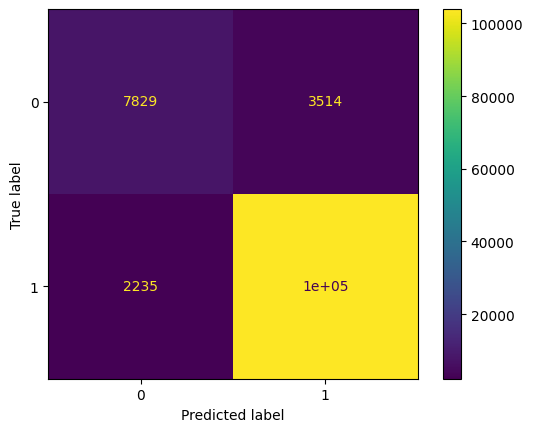

In [30]:
conf_matrix = confusion_matrix(y_test, preds_Xtest)
cm_disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
cm_disp.plot()
plt.show()

# Main Contribution

## Find all valid if-thens with all respective coverages and correctness, for all subgroups.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [31]:
# #Uncomment if you want to find new rules with different support

# ifthens_coverage_correctness = valid_ifthens_with_coverage_correctness(
#     X_test,
#     model=model,
#     sensitive_attribute='RACE CODE CD',
#     freqitem_minsupp = 0.01,
#     missing_subgroup_val="Unknown",
#     drop_infeasible = True,
#     drop_above = False
# )

# print(f"Number of if-thens: {len(ifthens_coverage_correctness)}")
# rules_by_if = rules2rulesbyif(ifthens_coverage_correctness)

In [32]:
from facts.utils import load_rules_by_if, save_rules_by_if

## Use this for loading rules from disk
rules_by_if = load_rules_by_if(computed_rules_file)

## Use this for saving rules on disk
#save_rules_by_if(precomputed_rules_file, rules_by_if)

In [33]:
K = 10

# keep K ifs with maximum coverage on Females
# TODO: the below is currently dataset dependent
# rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: e[1]["F"][0][1], reverse=True)[:K]

# keep K ifs with maximum absolute difference in correctness between Males and Females.
# TODO: the below is currently dataset dependent
rules_by_if_filtered = sorted(rules_by_if.items(), key=lambda e: abs(e[1]["WHI"][1][0][1]-e[1]["BLK"][1][0][1]), reverse=True)[:K]

rules_by_if_filtered = dict(rules_by_if_filtered)

print(recourse_report_reverse(rules_by_if_filtered))

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 1.61% covered
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with correctness 0.00%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with correctness 0.00%.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with correctness 0.00%.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with correctness 0.00%.
		M

## Macro Viewpoint

In [34]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'PREDICTOR RAT AGE AT LATEST ARREST':10,	'PREDICTOR RAT VICTIM SHOOTING INCIDENTS':1,	
'PREDICTOR RAT VICTIM BATTERY OR ASSAULT':1,	'PREDICTOR RAT ARRESTS VIOLENT OFFENSES':1,	'PREDICTOR RAT GANG AFFILIATION':1,
'PREDICTOR RAT NARCOTIC ARRESTS':1,	'PREDICTOR RAT TREND IN CRIMINAL ACTIVITY':1,	'PREDICTOR RAT UUW ARRESTS':1,	'SEX CODE CD':100,	'RACE CODE CD':100}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=True,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)

### Equal Cost of Effectiveness (Macro)

In [35]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="min-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr", "remove-fair-rules"],
)

pop_sizes = {sg: (X["RACE CODE CD"] == sg).sum() for sg in X["RACE CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1:
	Protected Subgroup 'BLK', 33.40% covered out of 209747
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'WHI', 32.88% covered out of 181990
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with correctness 57.84%.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK. Unfairness score = inf.
If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 28.37% covered out of 209747
		No recourses for this subgroup!
		Aggregate cost of the above recourses = inf
	Protected Subgroup 'WHI', 29.32% covered out of 181990
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0 with correctness 57.08%.
		Make PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, SEX CODE CD = F with correctness 54.28%.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK. Unfairness score = inf.
If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK'

### Equal Choice for Recourse

In [36]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_by_if,
    metric="num-above-thr",
    sort_strategy="abs-diff-decr-ignore-forall-subgroups-empty",
    top_count=10,
    cor_threshold=0.5,
    filter_sequence=["remove-below-thr"]
)

pop_sizes = {sg: (X["RACE CODE CD"] == sg).sum() for sg in X["RACE CODE CD"].unique()}
print(recourse_report_reverse(
    top_rules,
    population_sizes = pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True
))

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.07% covered out of 209747
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'WHI', 1.28% covered out of 181990
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 82.14%.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 60.71%.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with correctness 64.29%.
		Make PREDICTOR RAT GANG AFFILIATION = 0, P

## Micro viewpoint

We start by computing the cumulative effectiveness of the actions for each subgroup and each value of the protected attribute.

**Caution!** This step takes time. Uncomment the following block if you wish to run.

In [37]:
# rules_with_cumulative = facts.cum_corr_costs_all(rules_by_if, X_test, model, sensitive_attribute="race", params=params)

In [38]:
## Use this for loading rules from disk
rules_with_cumulative = load_rules_by_if(computed_rules_with_cumulative_file)

## Use this for saving rules on disk
# save_rules_by_if(computed_rules_with_cumulative_file, rules_with_cumulative)

# facts.update_costs_cumulative(rules_with_cumulative, params)

### Equal (Conditional) Mean Recourse

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.67% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 99.32% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
	

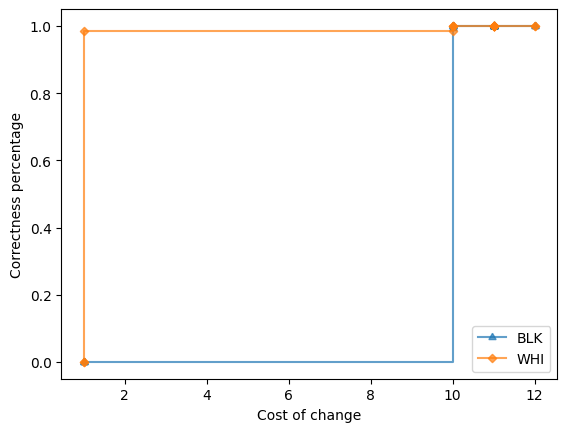

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 98.93% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
	

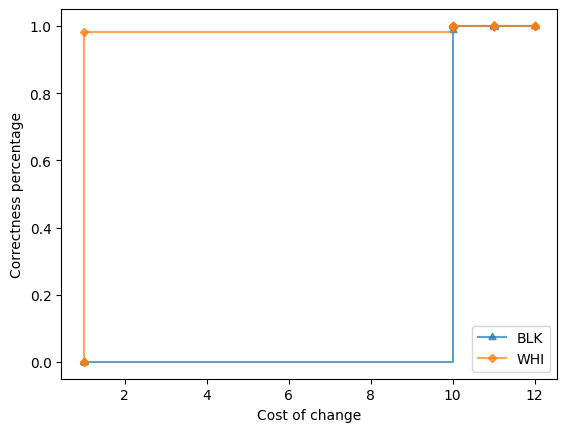

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60 with effectiveness 100.00% and counterfactual cost

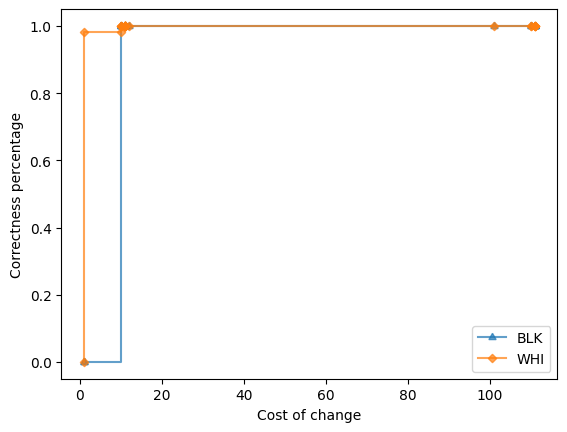

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 98.46% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 40-50 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 50-60 with effectiveness 100.00% and counterfactual cost 

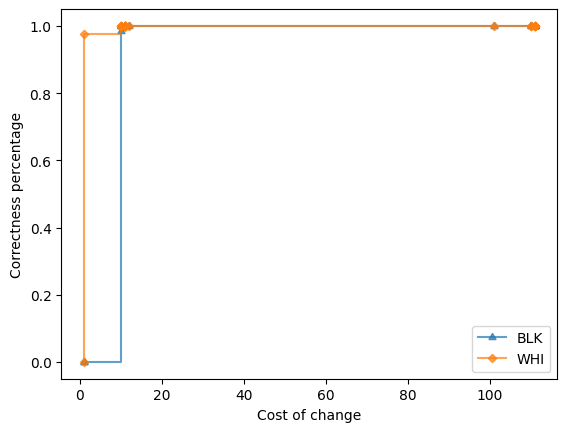

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.96% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 84.76% and counterfactual cost = 11.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40, PREDICTOR RAT GAN

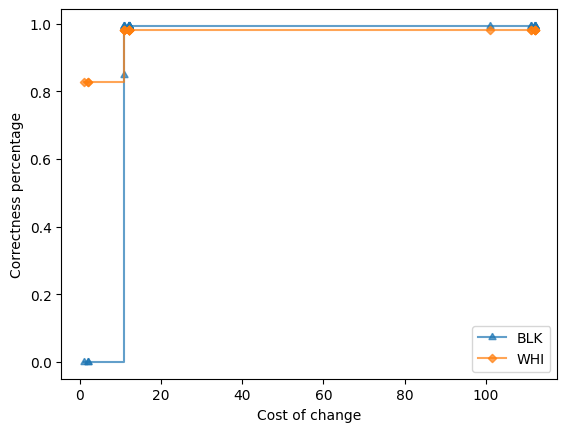

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.06% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILI

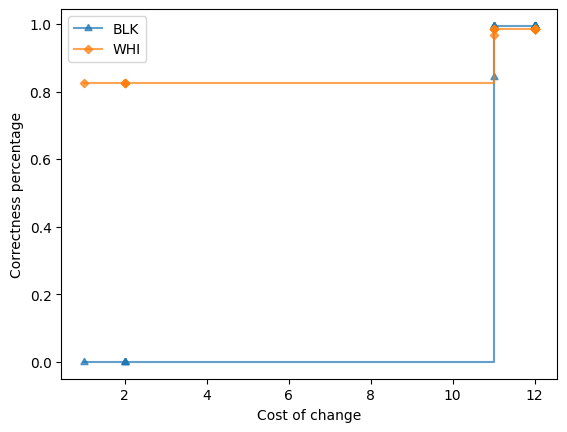

In [39]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=10,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["RACE CODE CD"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["RACE CODE CD"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.68% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS

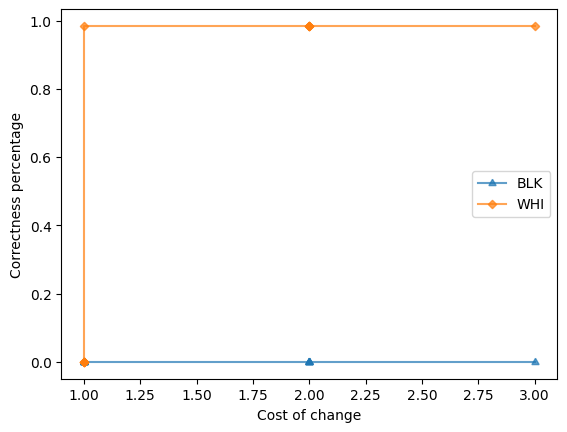

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION

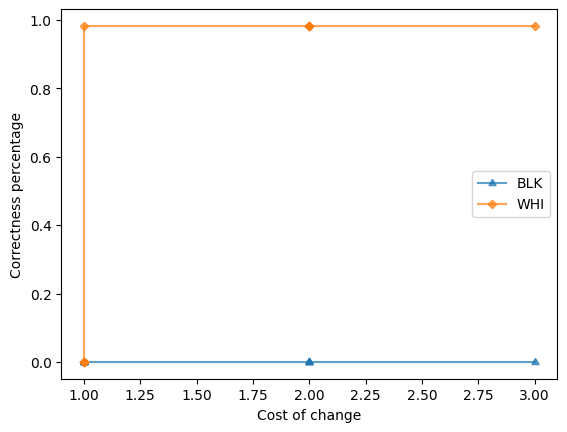

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT

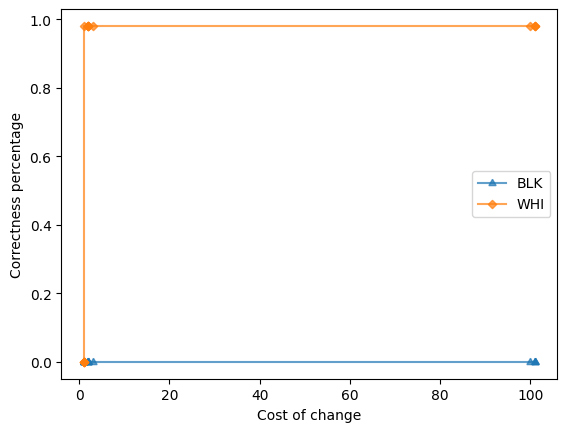

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT

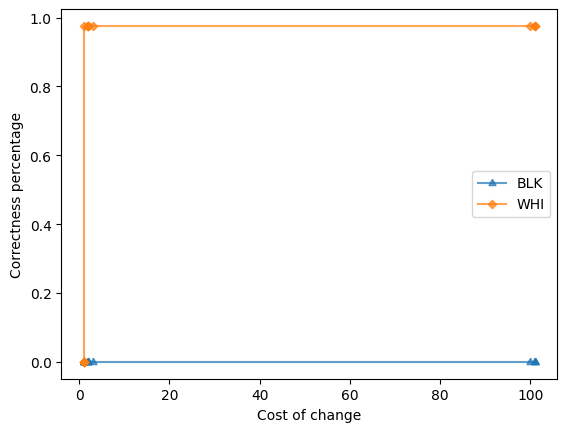

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.93% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.01% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 4.82% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CRIMINA

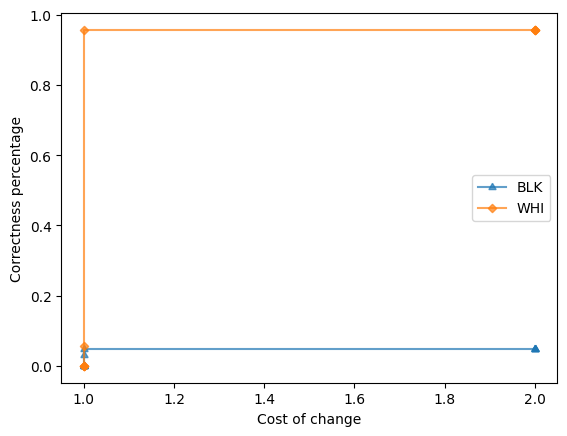

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3]:
	Protected Subgroup 'BLK', 17.98% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND I

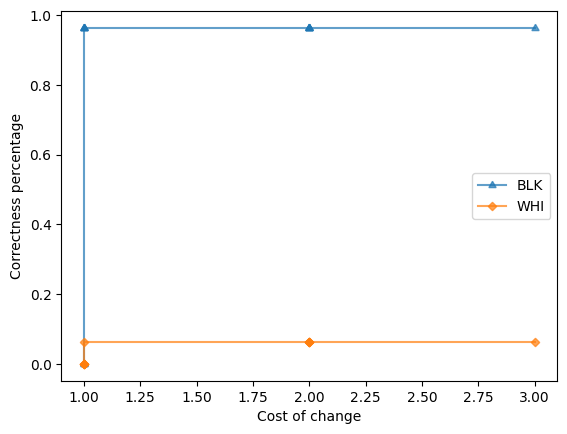

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.44% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

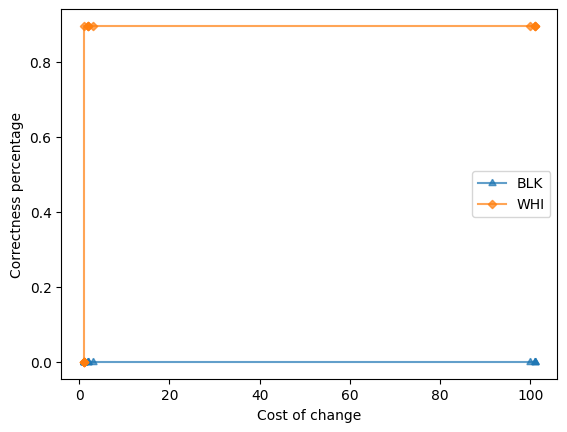

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.37% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.23% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 5.65% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT

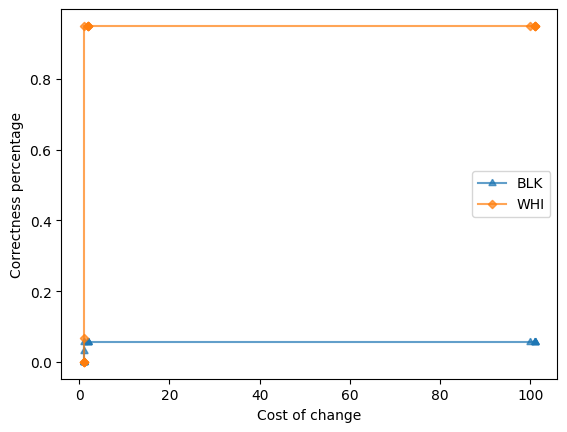

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINA

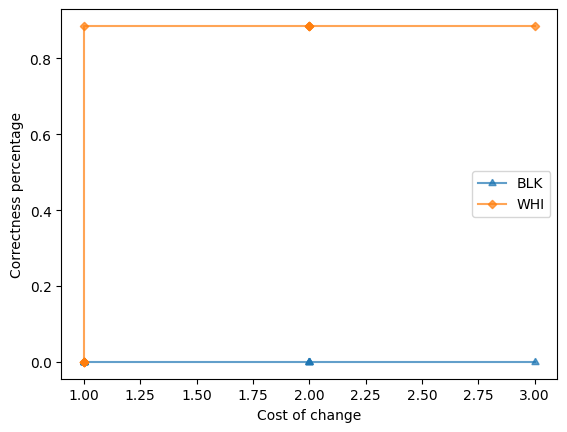

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.01% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 

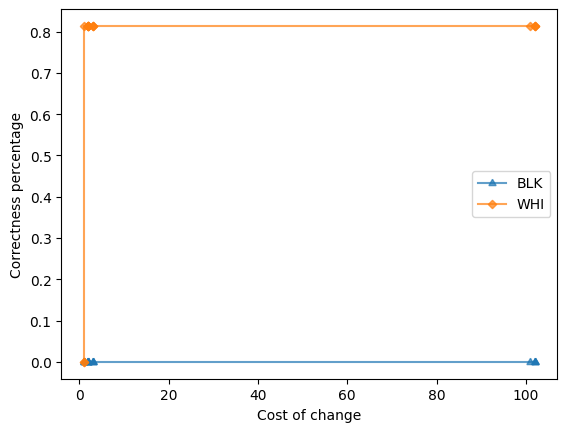

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.11% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT 

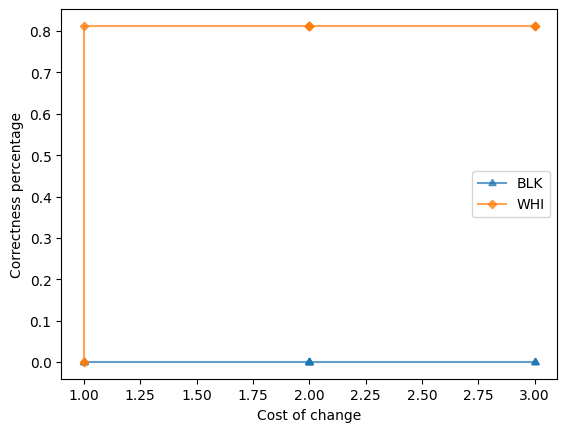

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 1.07% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0

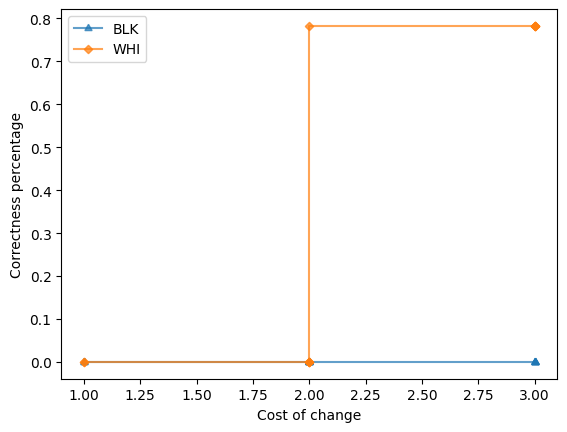

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.07% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GAN

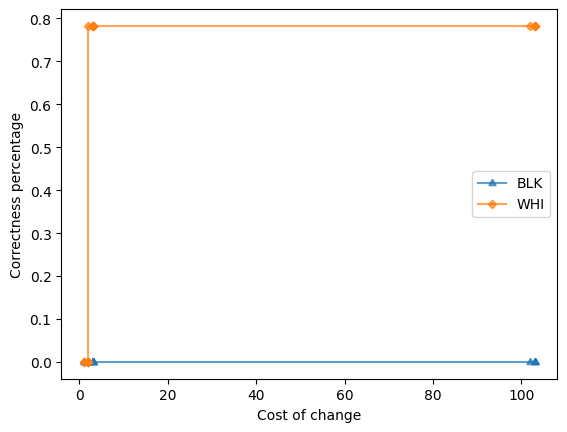

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 4.11% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 10.34% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 10.34% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR R

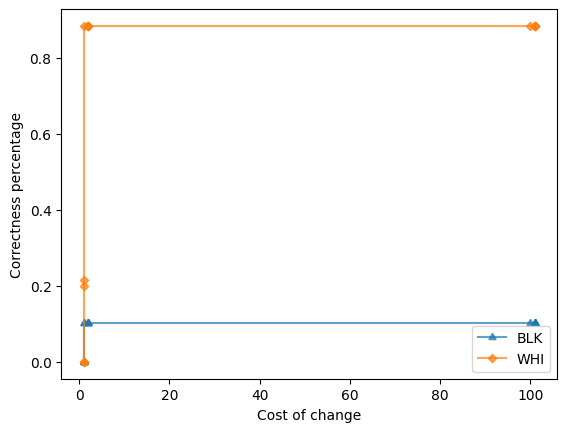

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.92% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTI

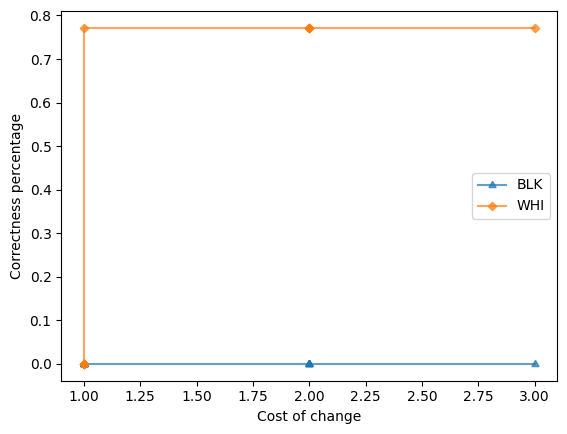

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.86% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.36% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 8.82% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.09
	Protected Subgroup 'WHI', 2.83% covered out of 2210
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual c

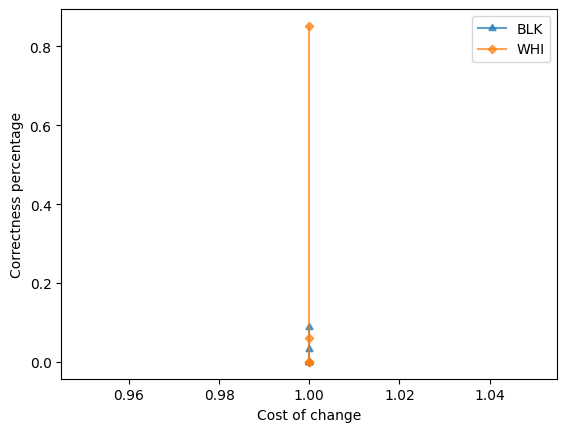

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.26% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 2.62% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 9.42% and counterfactual cost = 1.0.
		Make SEX CODE CD = F with effectiveness 9.42% and counterfactual cost = 100.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], SEX CODE CD = F with effectiveness 9.42% and c

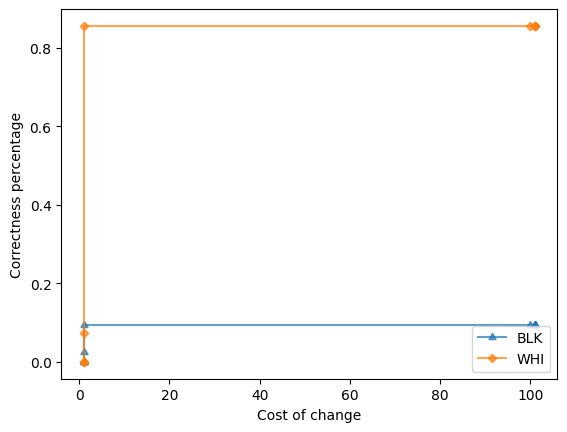

In [40]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        # "remove-fair-rules",
        # "keep-only-min-change"
    ],
    params=params
)

pop_sizes = {sg: ((X_test["RACE CODE CD"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["RACE CODE CD"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric= True
)

### Equal Cost of Effectiveness (micro)

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 9.26% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 23.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 73.61% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 9.35% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 43.72% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


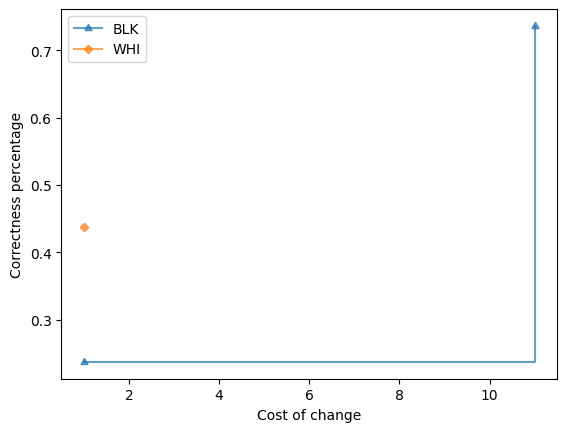

If PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1:
	Protected Subgroup 'BLK', 7.68% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 25.37% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 86.02% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 5.56% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 48.18% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


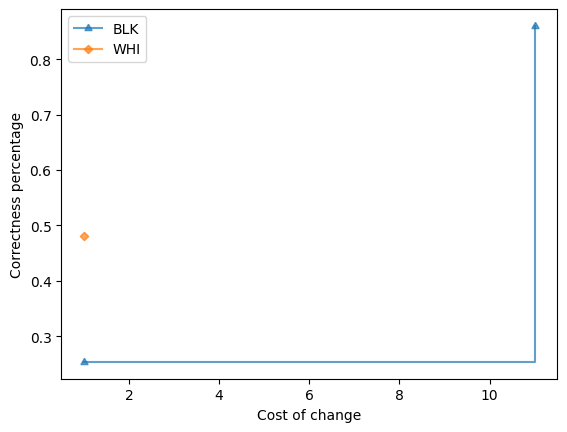

If PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 7.26% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 24.66% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 86.15% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 5.29% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 48.46% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


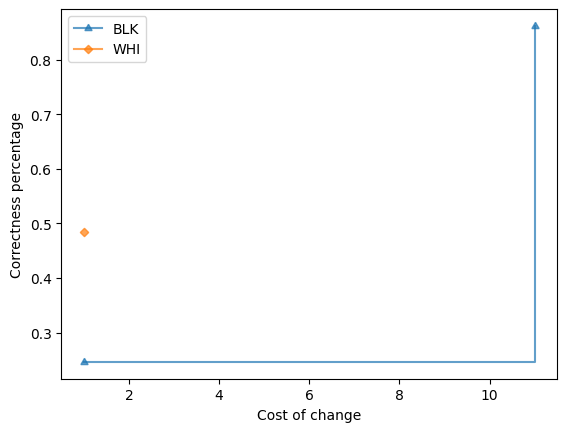

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 7.24% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 15.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 67.88% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 8.57% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 39.77% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


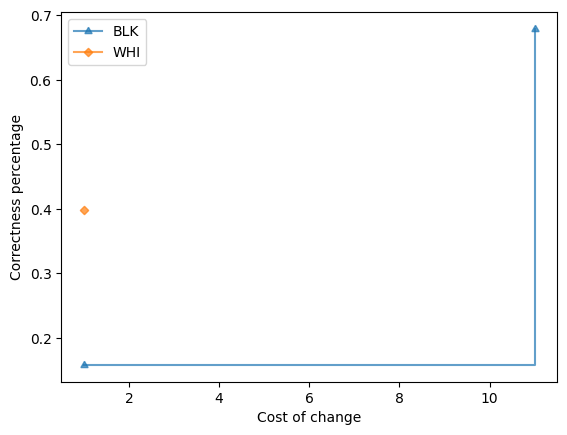

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 3.99% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 22.70% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 22.70% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 76.64% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 5.02% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 47.52% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


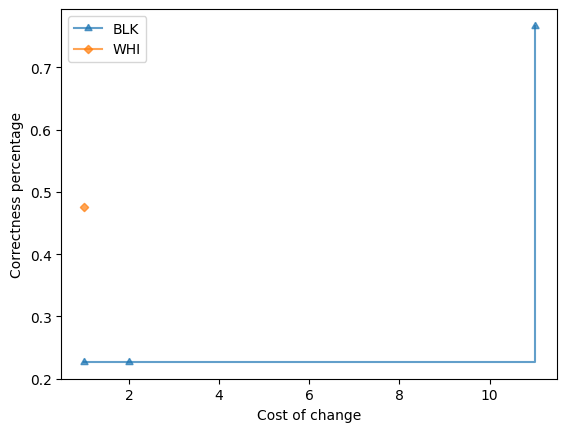

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 3.95% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 28.71% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 92.74% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 5.88% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 58.47% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


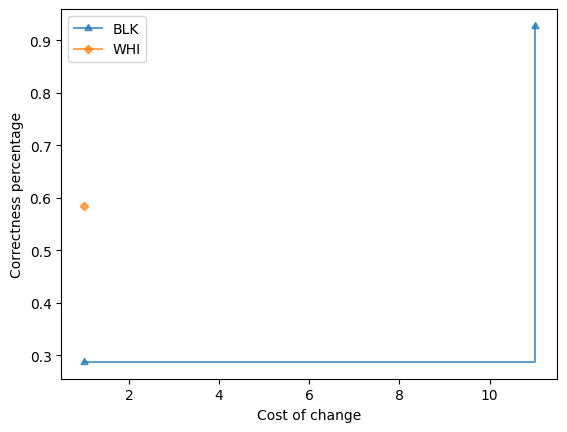

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 3.68% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 29.55% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 29.55% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 29.55% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 29.55% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 77.32% and counterfactual cost = 11.0.
		Aggregate cost of the above r

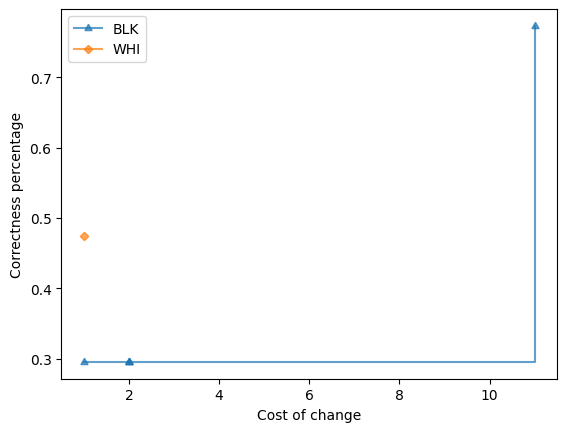

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.85% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 17.30% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 17.30% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 17.30% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 73.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 3.28% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 42.03%

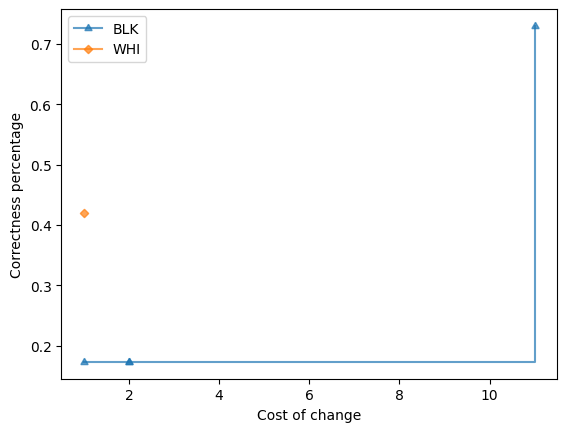

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.78% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 30.14% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.41% covered out of 2210
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 8.33% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 83.33% and counterfactual cost = 11.0.
		Aggregate cost of the ab

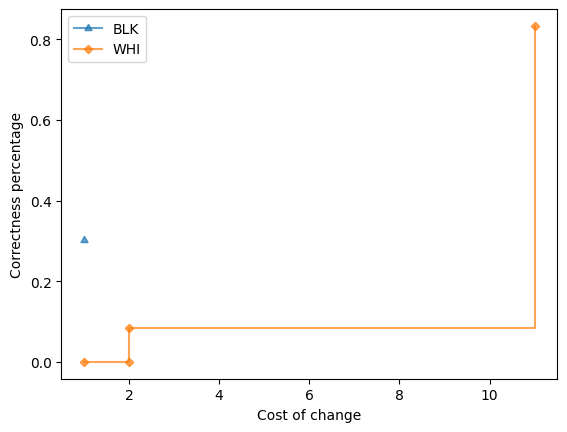

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1:
	Protected Subgroup 'BLK', 2.43% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 22.94% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 64.71% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 1.19% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 40.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


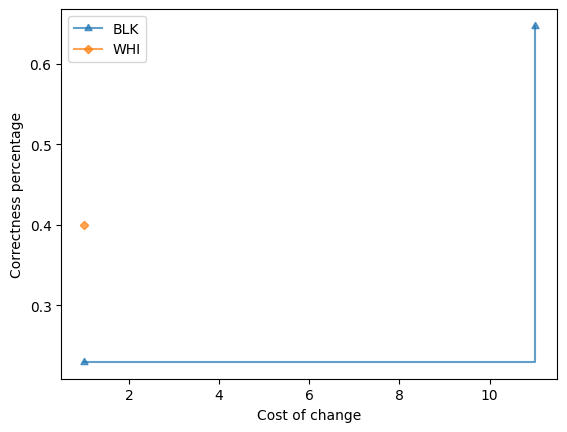

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.15% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 80.00% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 2.42% covered out of 2210
		Make PREDI

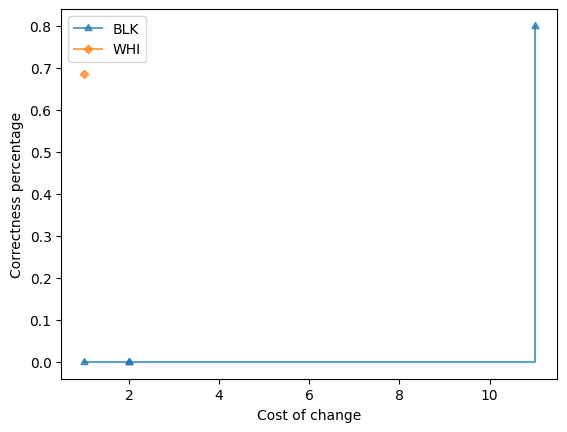

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.06% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILI

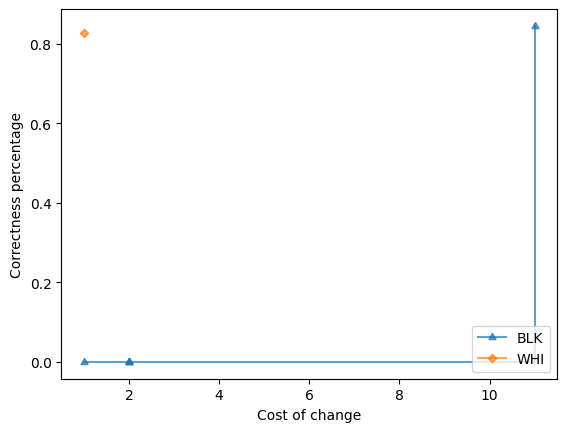

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.96% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 21.13% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 62.68% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 1.05% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 41.67% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


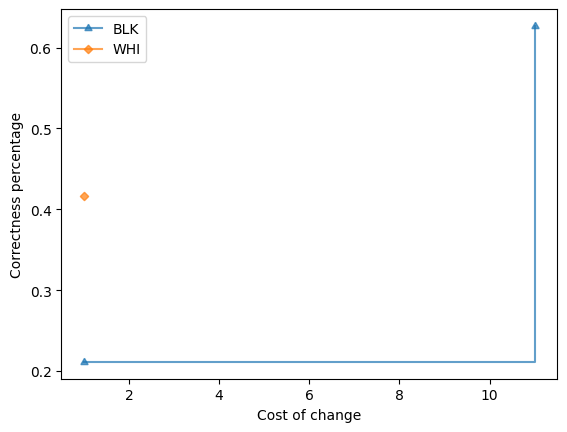

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1:
	Protected Subgroup 'BLK', 1.72% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 16.99% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 19.61% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 69.28% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 2.01% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 39.02% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


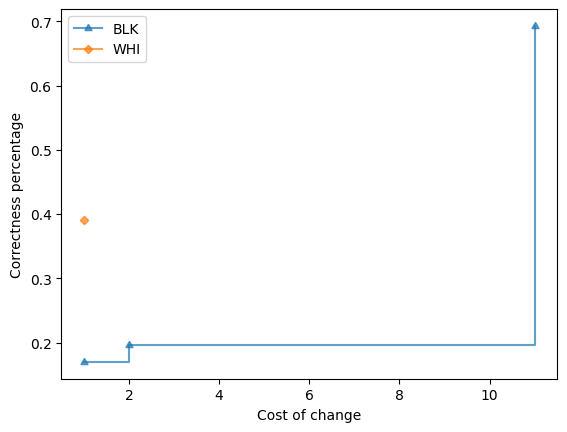

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.59% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 12.86% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 14.29% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 67.14% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 1.96% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 35.90% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


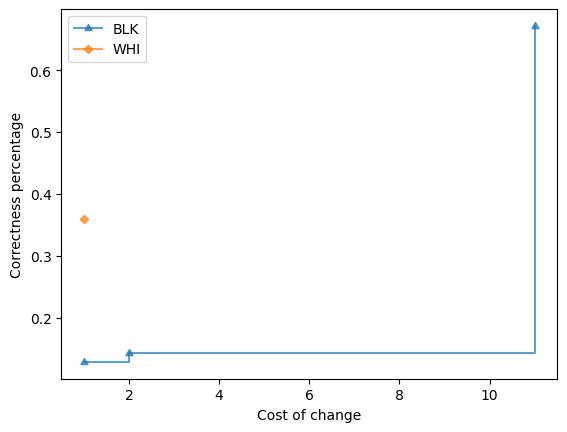

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1:
	Protected Subgroup 'BLK', 1.59% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 37.84% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.41% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 29.63% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 29.63% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 29.63% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM SHOOTING INC

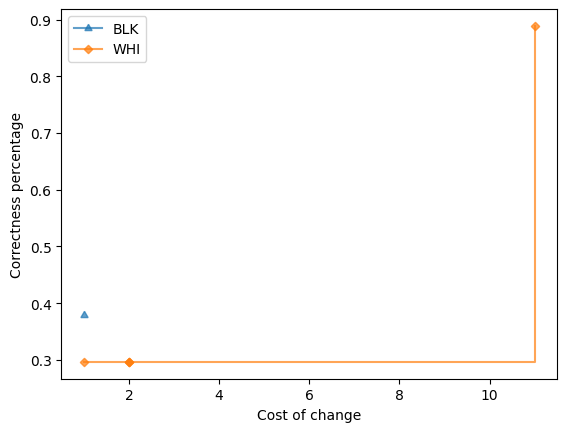

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.32% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 24.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 24.21% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 24.21% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 77.89% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 1.82% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR A

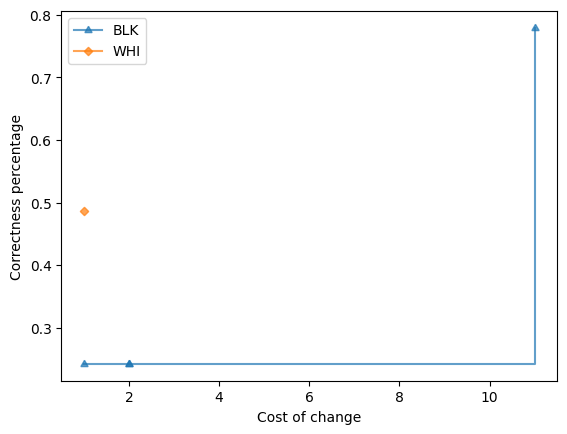

If PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 1:
	Protected Subgroup 'BLK', 1.32% covered out of 7854
		Make PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 41.09% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.14% covered out of 2210
		Make PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1]

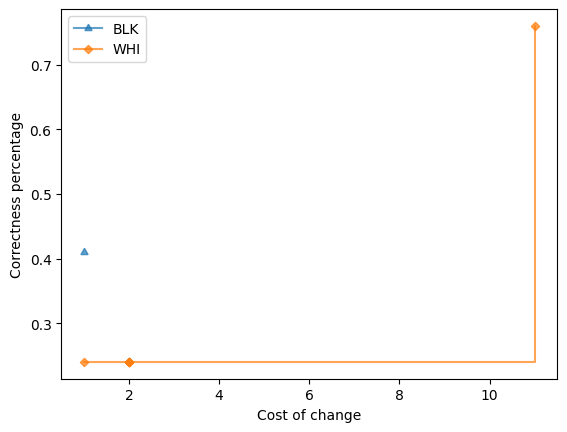

If PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.29% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 14.41% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 27.93% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 27.93% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 27.93% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 27.93% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND 

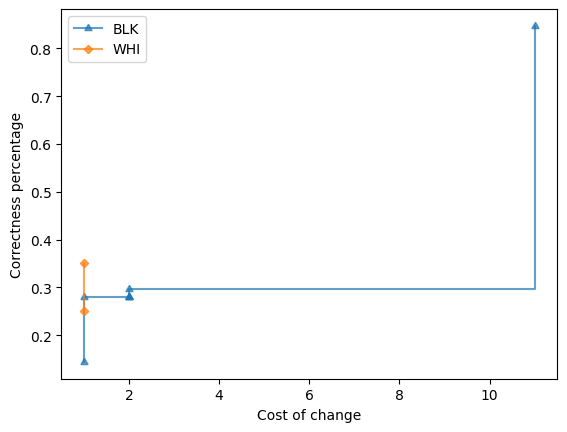

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1:
	Protected Subgroup 'BLK', 1.28% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 37.35% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.05% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 25.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 25.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 25.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3], PREDICTOR 

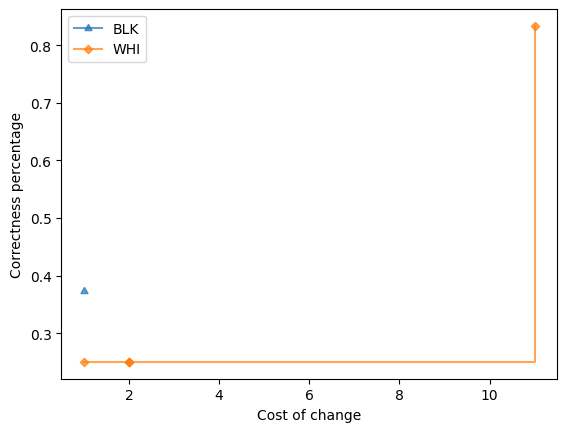

If PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.28% covered out of 7854
		Make PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 41.73% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.14% covered out of 2210
		Make PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0 with effectiveness 24.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVI

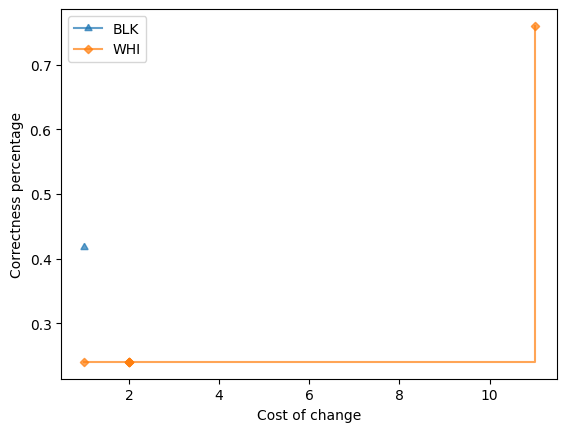

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2], SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.15% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 44.09% and counterfactual cost = 11.0.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'WHI', 1.55% covered out of 2210
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL

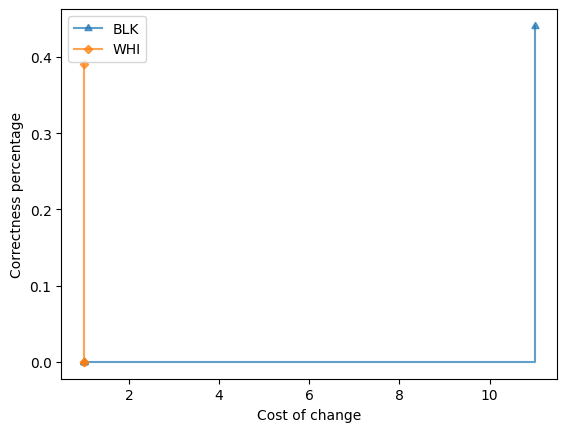

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.09% covered out of 7854
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 36.00% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'WHI', 1.05% covered out of 2210
		Make PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 26.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 26.09% and counterfactual cost = 2.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0 with effectiveness 26.09% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PRED

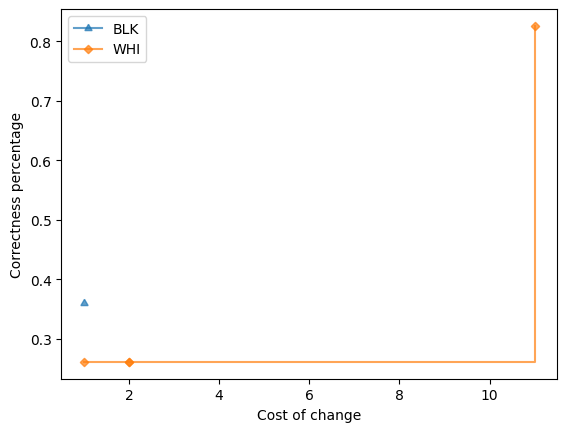

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 2:
	Protected Subgroup 'BLK', 1.05% covered out of 7854
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 15.12% and counterfactual cost = 2.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 44.19% and counterfactual cost = 12.0.
		Aggregate cost of the above recourses = 12.00
	Protected Subgroup 'WHI', 1.00% covered out of 2210
		Make PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0 with effectiveness 50.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 2.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 10.0.
	Cumulative effectiveness plot for the above recourses:


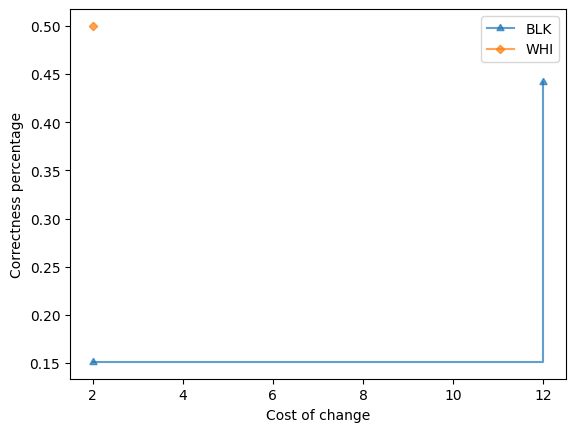

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.04% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NAR

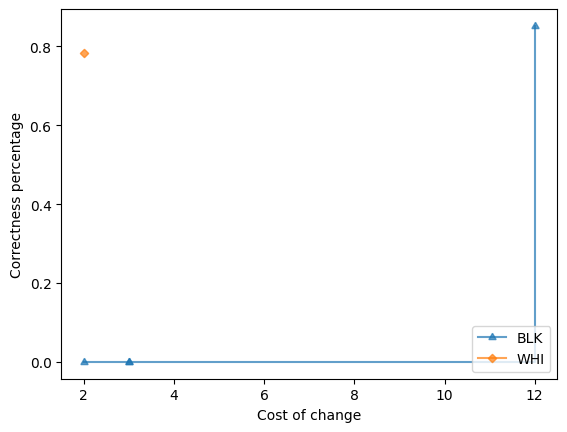

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 1:
	Protected Subgroup 'BLK', 14.19% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 7.73% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 71.44% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'WHI', 28.86% covered out of 2210
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 50.66% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:


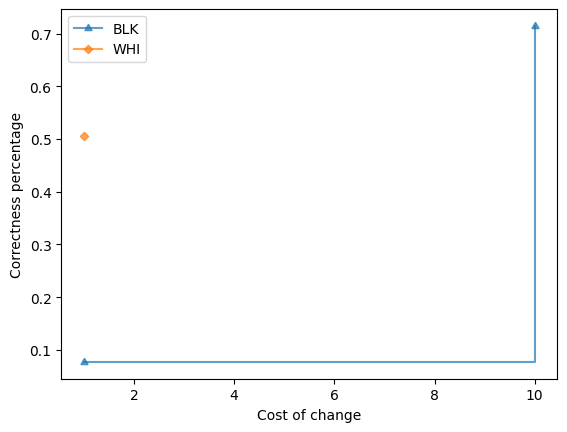

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 1, SEX CODE CD = M:
	Protected Subgroup 'BLK', 12.63% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 2.60% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 68.95% and counterfactual cost = 10.0.
		Aggregate cost of the above recourses = 10.00
	Protected Subgroup 'WHI', 25.63% covered out of 2210
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 47.45% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 1.00
	Bias against BLK due to Equal Effectiveness. Unfairness score = 9.0.
	Cumulative effectiveness plot for the above recourses:


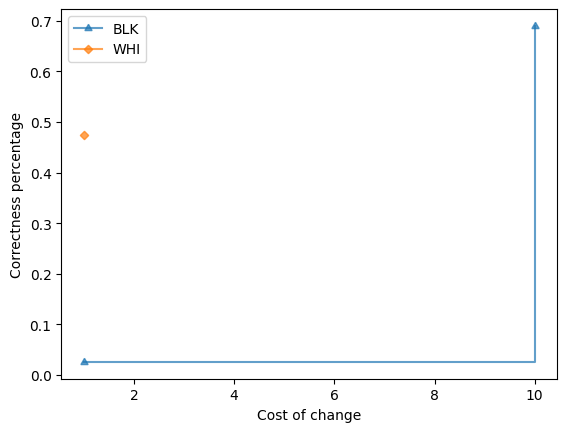

In [41]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        # "keep-only-min-change",
        
    ],
    cor_threshold = 0.3,
    params=params
)

pop_sizes = {sg: ((X_test["RACE CODE CD"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["RACE CODE CD"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

### Equal Effectiveness Within Budget

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.68% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS

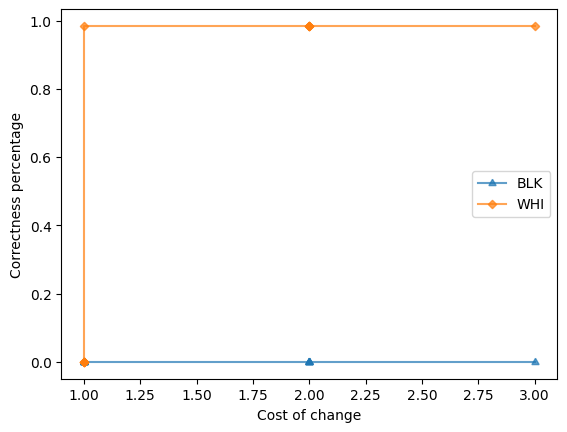

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION

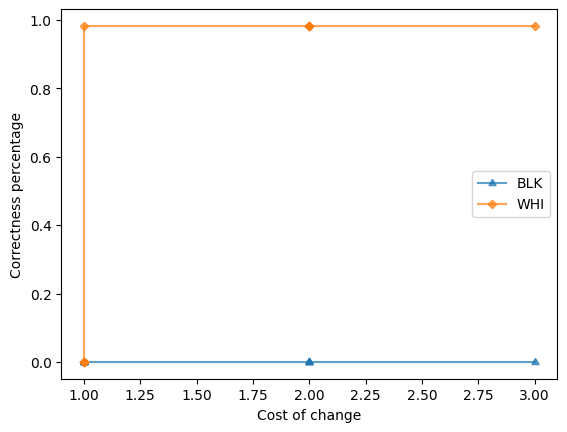

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.13% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT

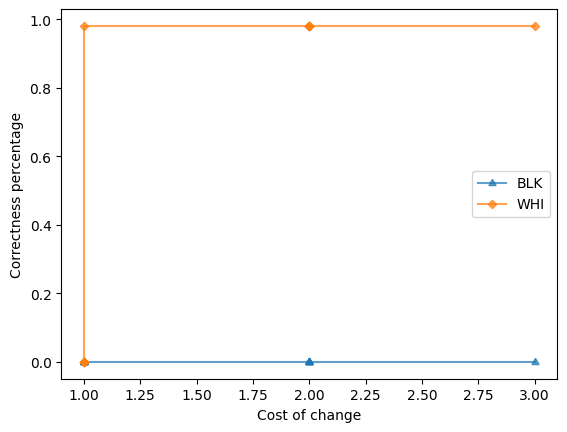

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.73% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT

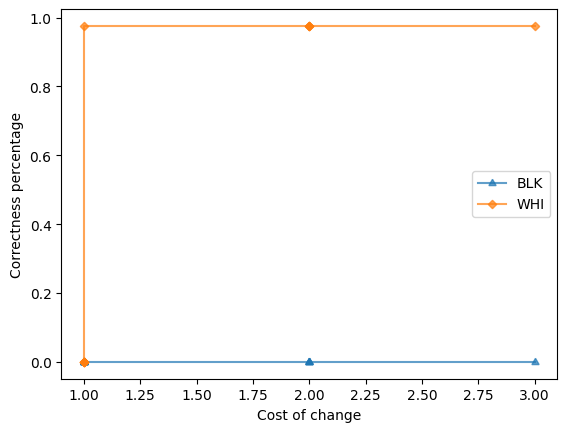

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 1.93% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.01% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 4.82% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT TREND IN CRIMINA

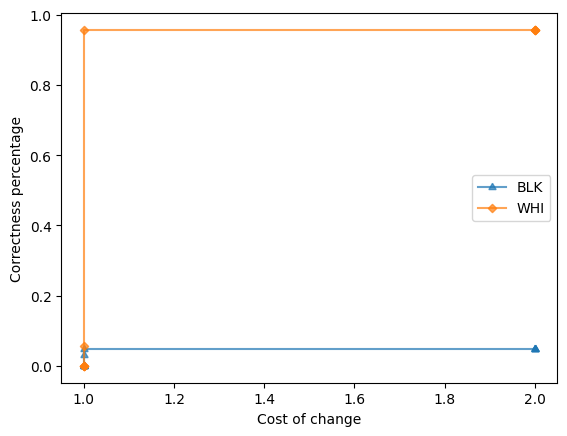

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3]:
	Protected Subgroup 'BLK', 17.98% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.35% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND I

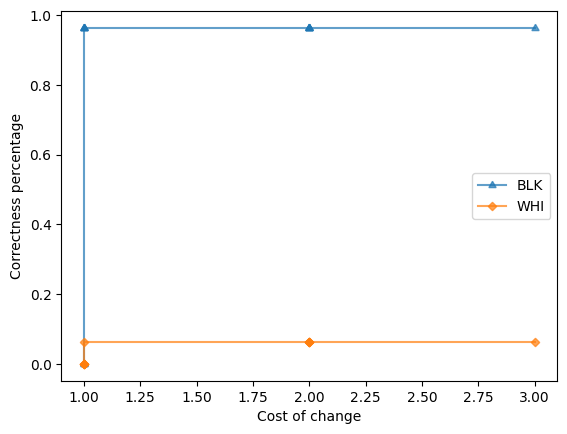

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.44% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

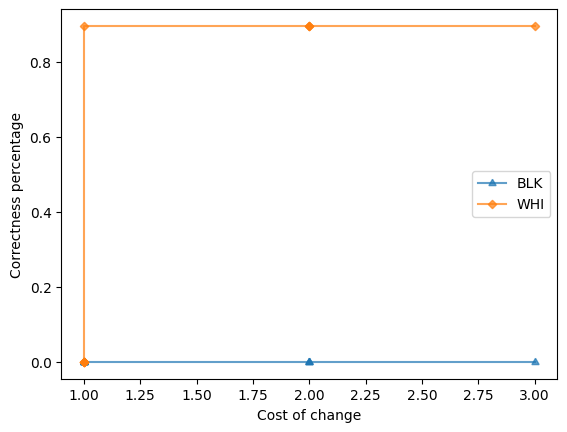

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.37% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.23% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 5.65% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT

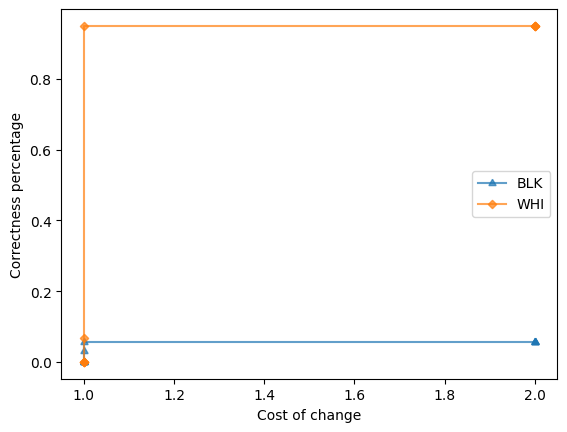

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINA

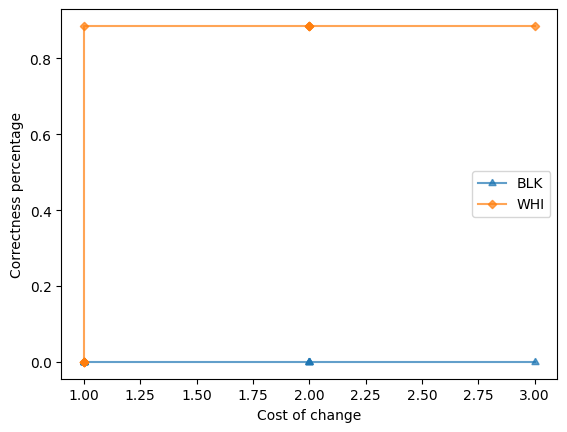

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.96% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'WHI', 1.87% covered out of 2210
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 82.76% and counterfactual cost = 1.0.
		Make PREDIC

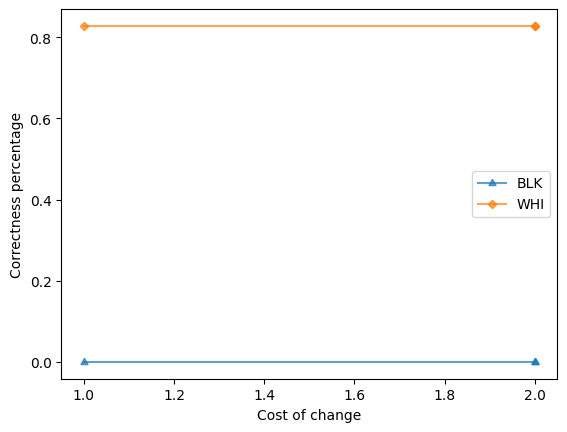

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.06% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 2.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'WHI', 2.

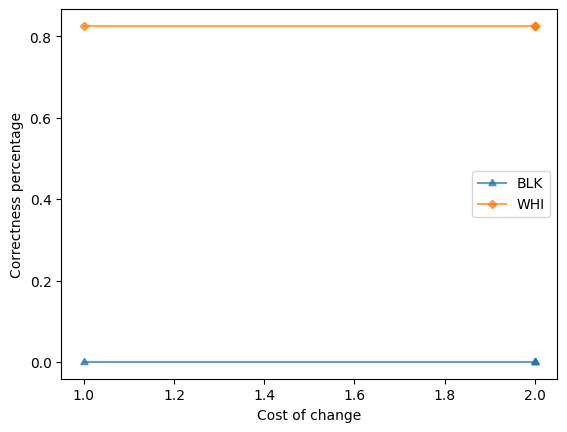

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.01% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 

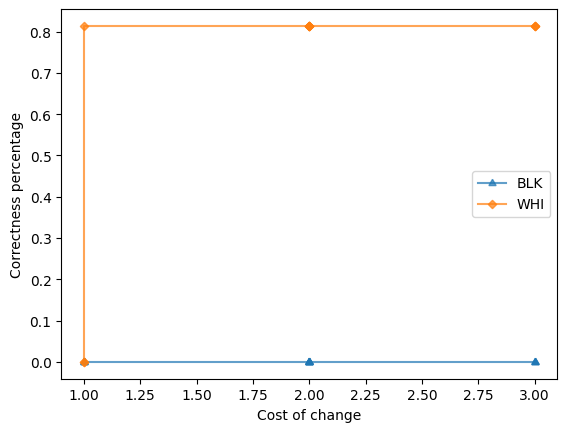

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.11% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT 

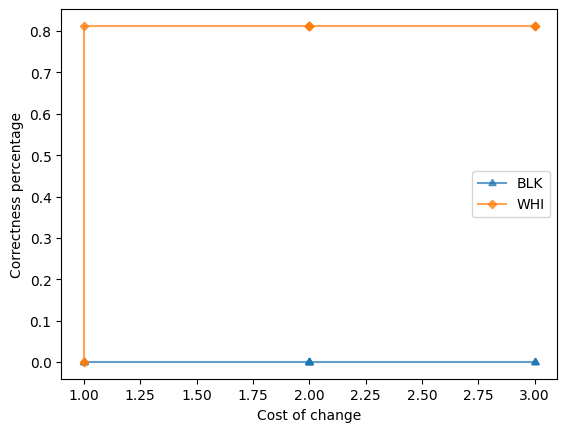

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 1.07% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0

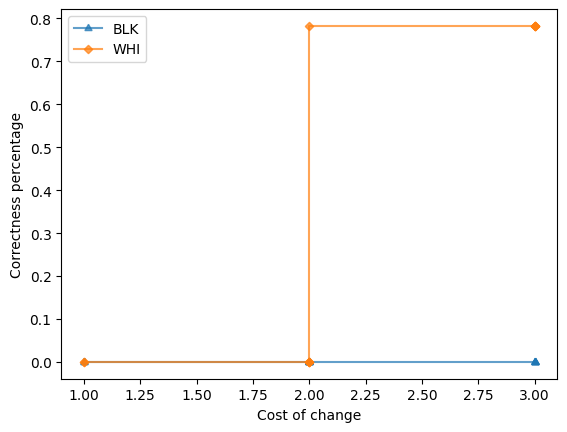

If PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.07% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GAN

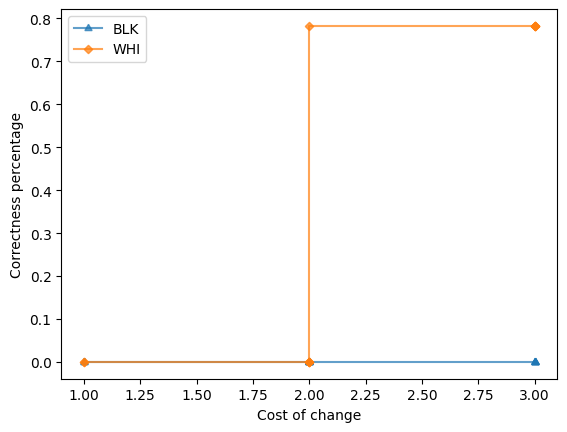

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 1.04% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY =

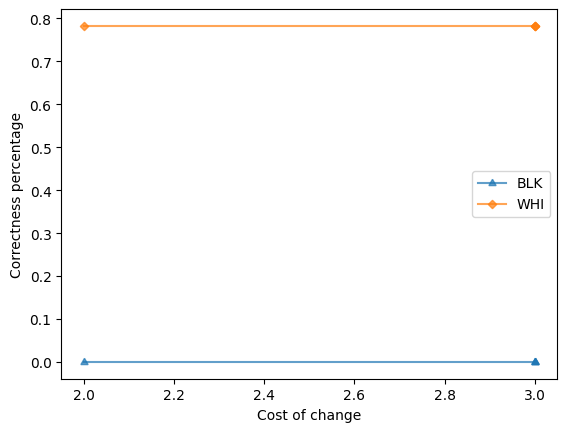

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 1.04% covered out of 7854
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0 with effectiveness 0.00% and counterfactual cost = 2.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Make PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 3.0.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'WHI', 1.60% covered out of 2210
		Ma

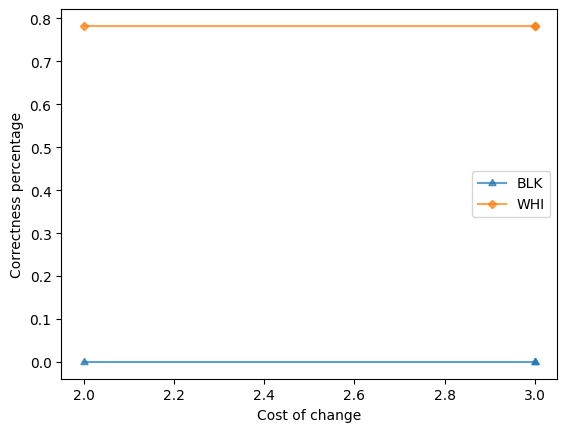

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 4.11% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 10.34% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 10.34% and counterfactual cost = 1.0.
		Make PREDICTOR RAT GANG AFFILIATION = 1, PREDICTOR R

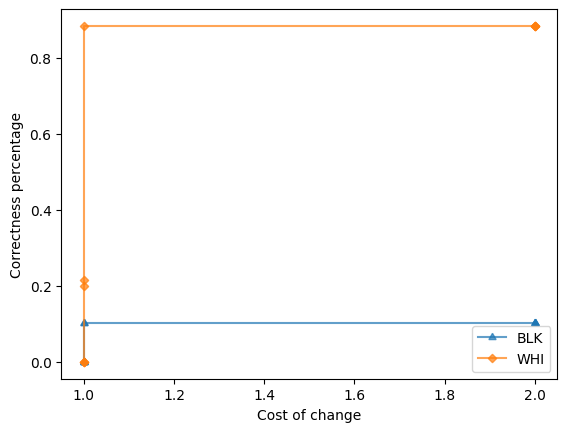

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 2.92% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTI

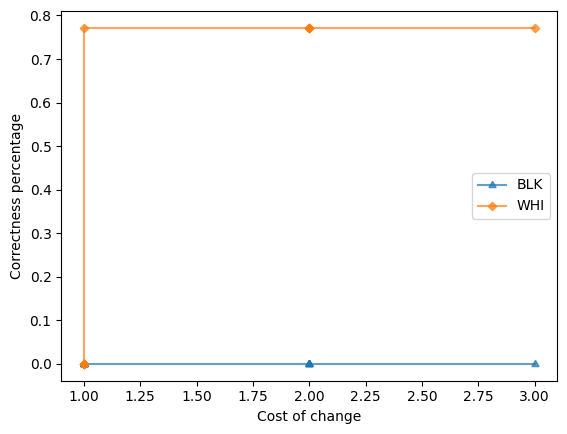

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 2.86% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 3.36% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 8.82% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.09
	Protected Subgroup 'WHI', 2.83% covered out of 2210
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual c

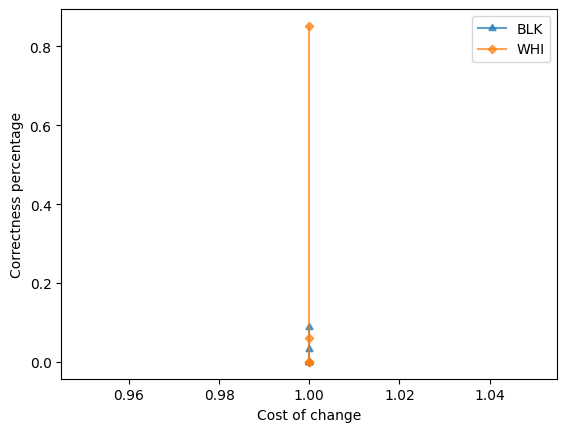

If PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, SEX CODE CD = M:
	Protected Subgroup 'BLK', 2.26% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 2.62% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 9.42% and counterfactual cost = 1.0.
		Aggregate cost of the above recourses = 0.09
	Protected Subgroup 'WHI', 2.37% covered out of 2210
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 0.00% and

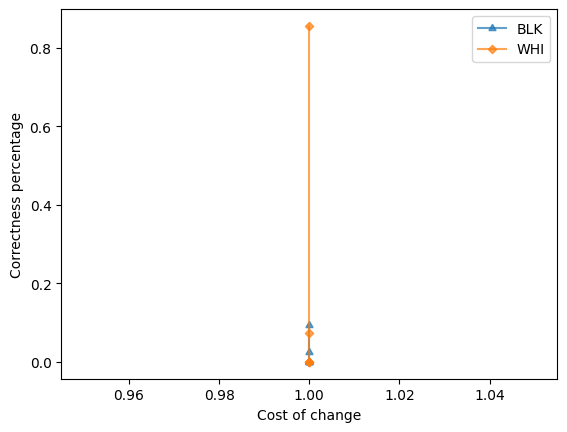

In [42]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
        #"remove-below-thr",
        #"keep-only-min-change",
        
    ],
    cost_threshold = 10,
    params=params
)

pop_sizes = {sg: ((X_test["RACE CODE CD"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["RACE CODE CD"].unique()}
print_recourse_report_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric = True
)

### Fair Effectiveness-Cost Trade-Off

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 6.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 94.02% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.44% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTO

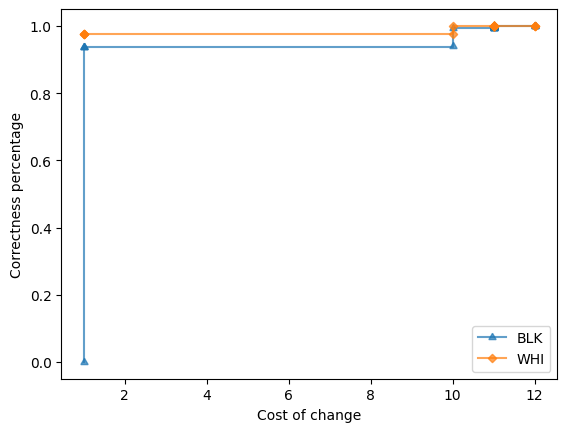

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 6.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.83% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 94.02% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.44% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT 

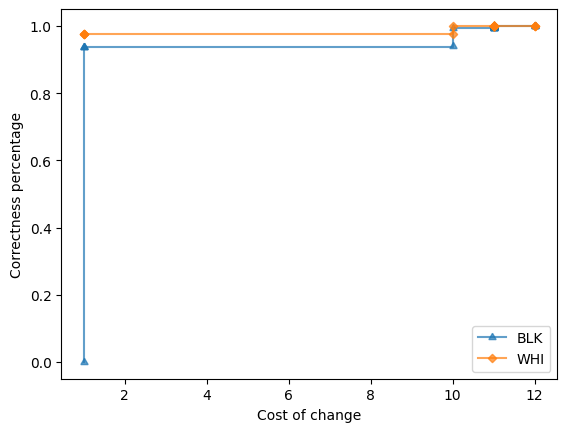

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARC

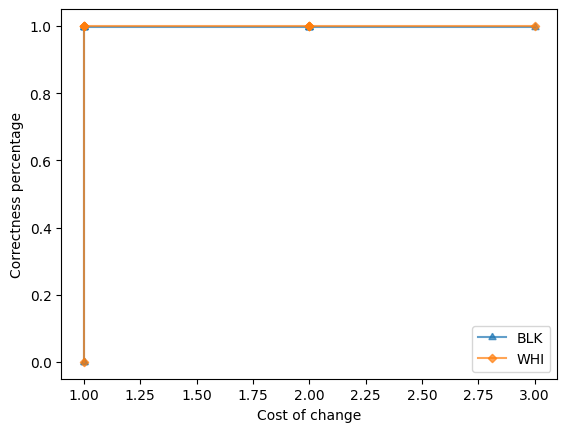

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

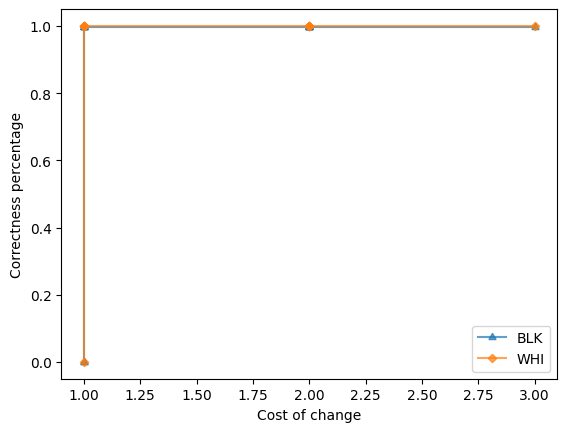

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDI

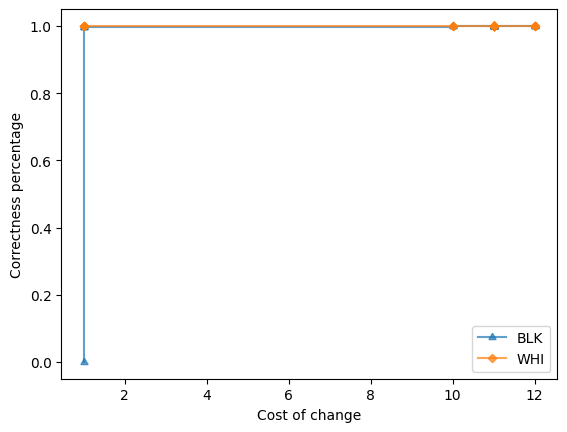

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 6.02% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 99.80% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.00% and counterfa

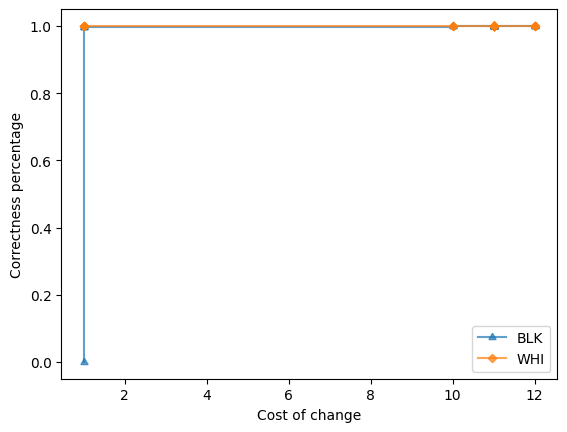

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.27% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.54% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.81% and counterfact

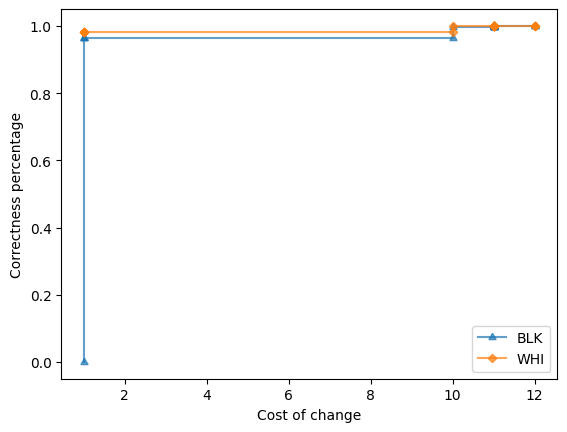

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.27% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.54% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.54% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 99.81% and counterfactual cost = 10.0.
		Make PREDICT

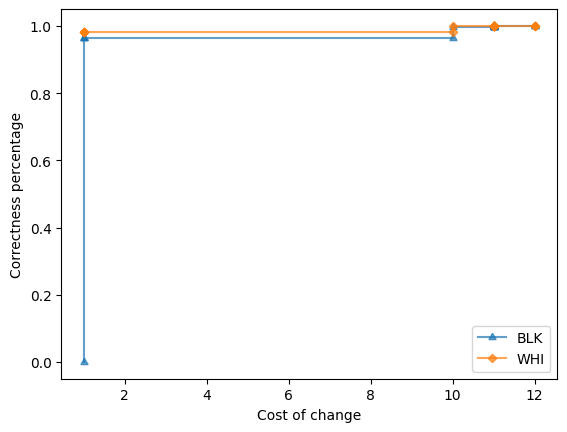

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and cou

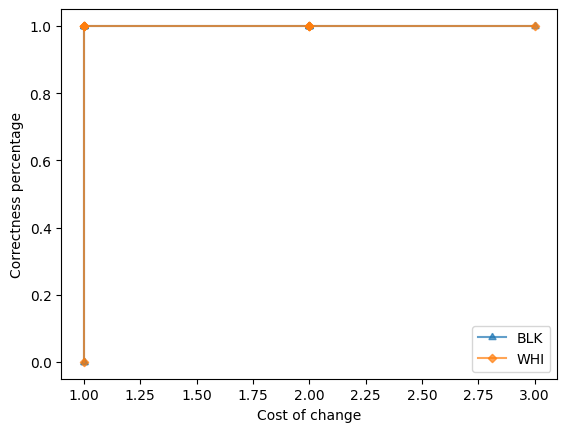

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST 

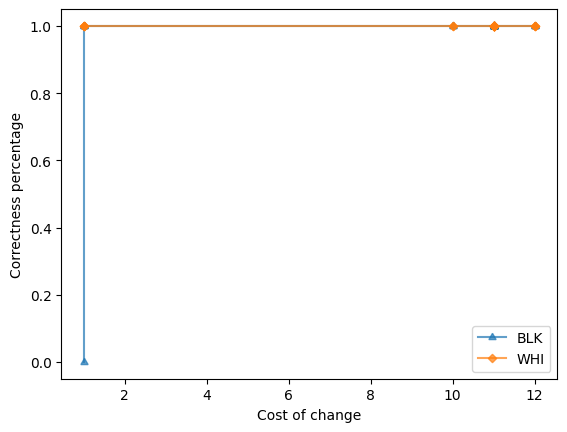

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 100.

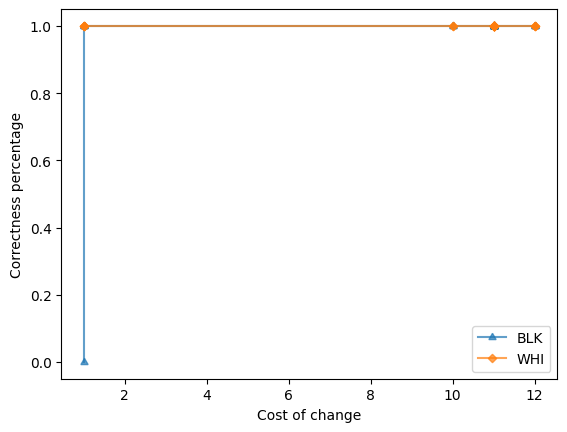

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.00% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make 

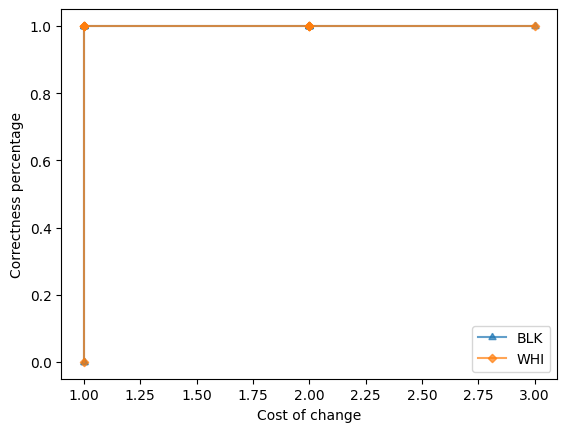

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.99% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 94.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARC

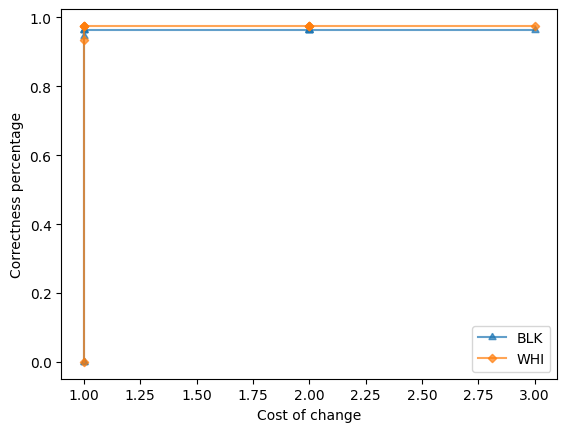

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 6.99% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 94.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.43% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT

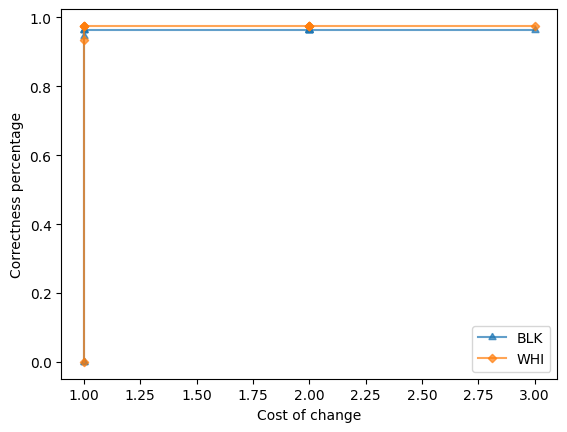

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 7.64% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 88.33% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with

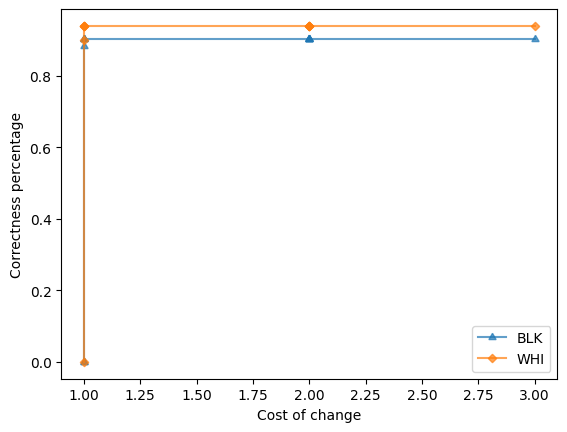

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 7.64% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 88.33% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 90.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIM

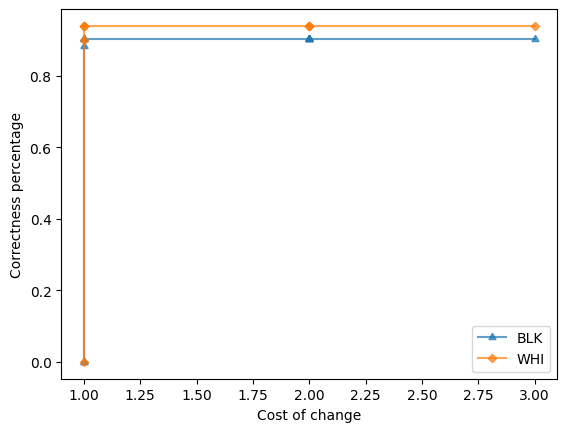

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.98% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (

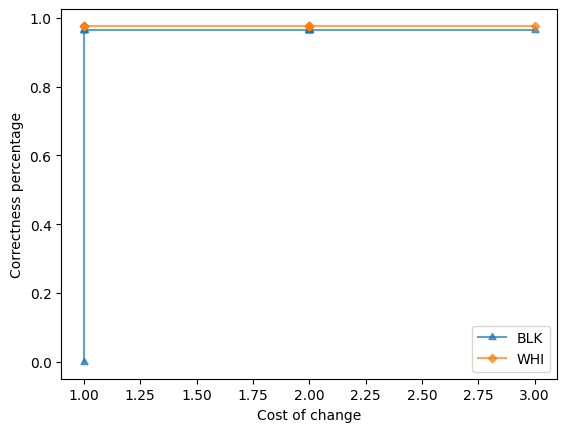

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.98% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 96.53% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 9

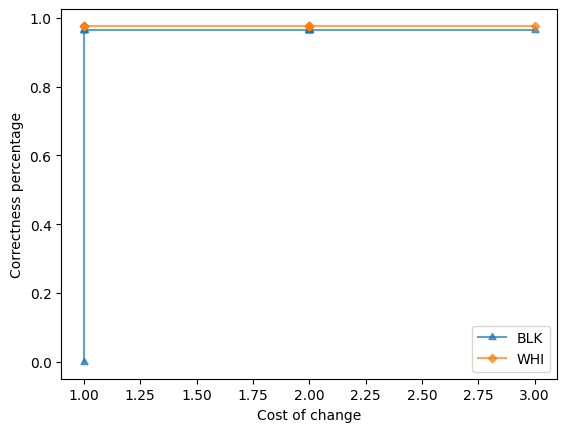

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 6.22% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.48% and counterfactual cost = 2.0.
		Make P

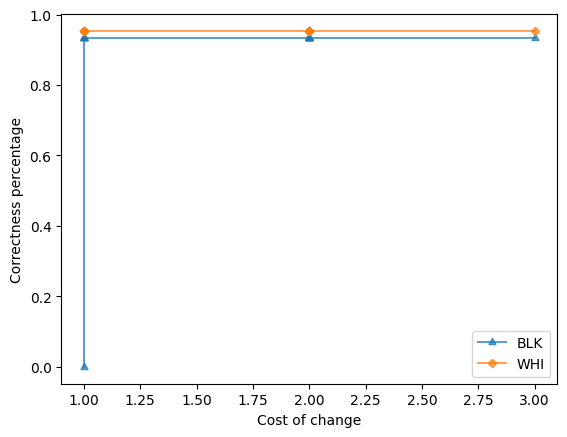

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 6.22% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 93.48% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 93.48% and coun

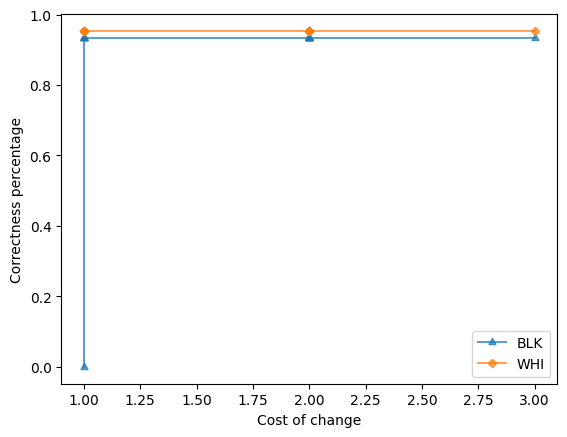

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 11.08% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.11% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 62.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 63.47% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CR

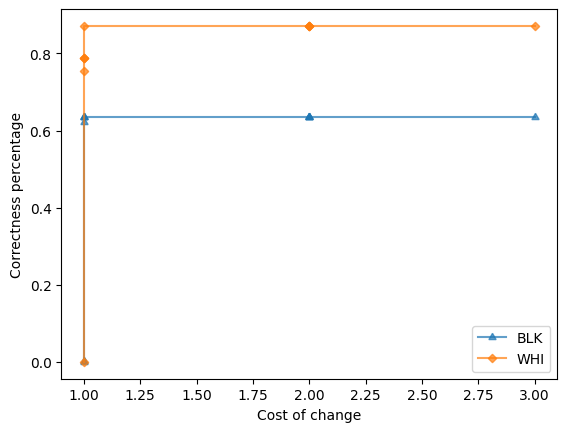

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 9.85% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.12% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 64.75% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRI

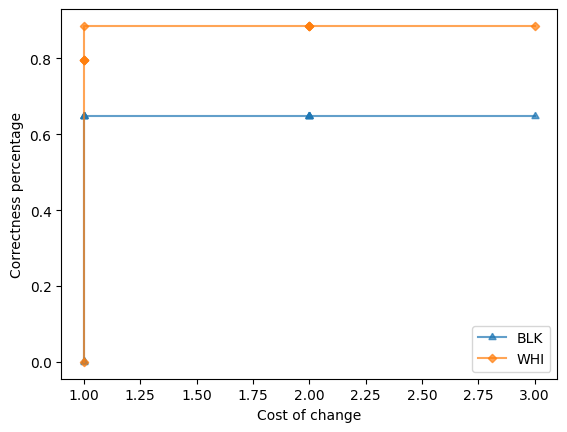

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 9.72% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.13% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 65.20% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 65.20% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 65.20% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 65.20% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NAR

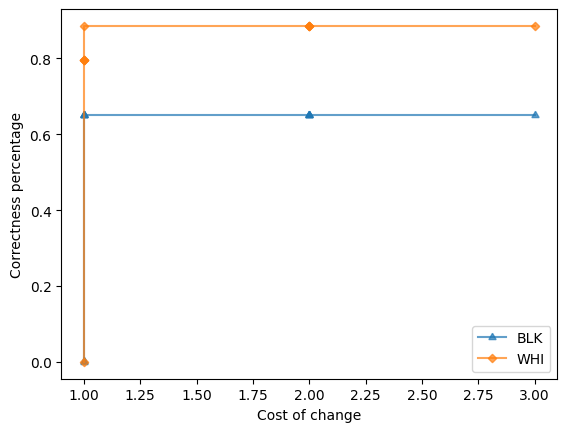

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 10.34% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 59.41% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 59.41% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 59.41% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 80.36% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 95.15% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND 

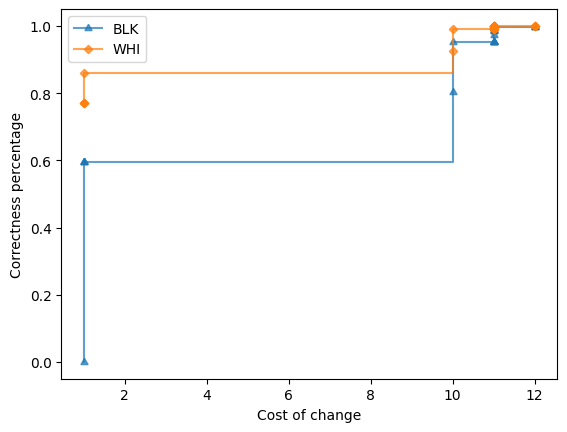

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 5.56% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 95.09% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 

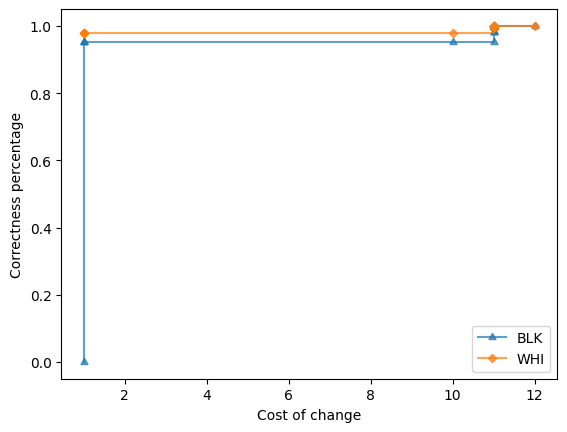

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3]:
	Protected Subgroup 'BLK', 5.56% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 95.09% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 95.09% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 95.09% 

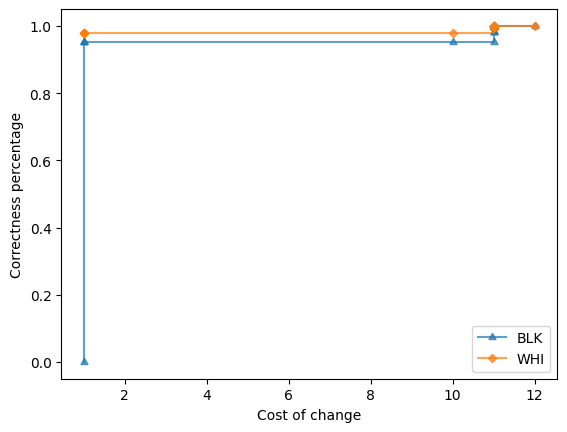

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, 

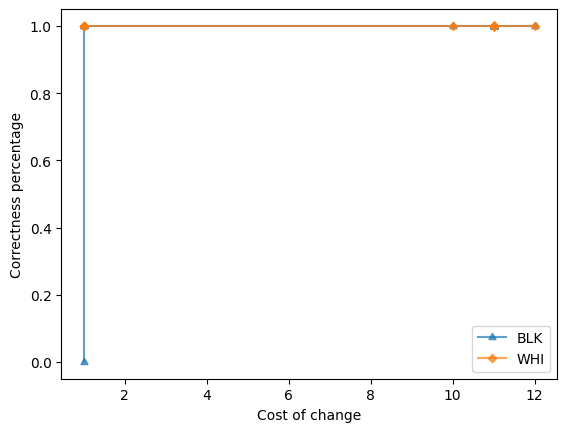

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make

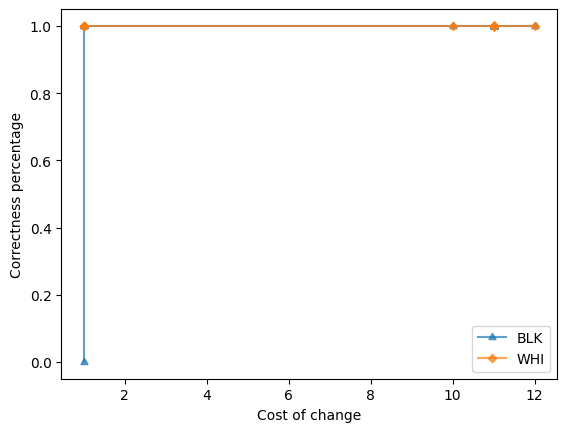

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS 

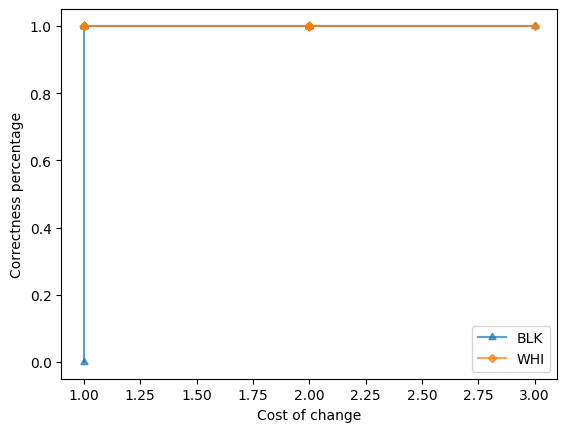

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST AR

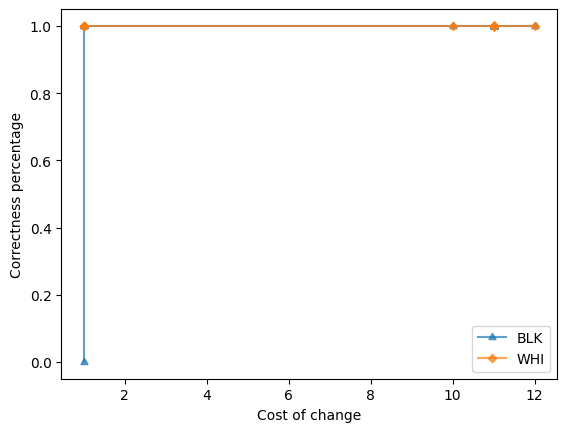

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRI

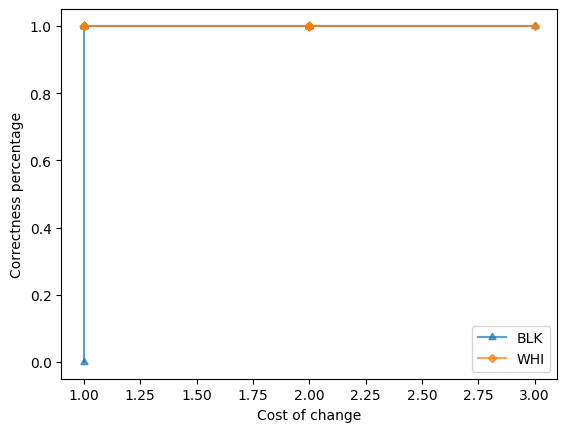

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY

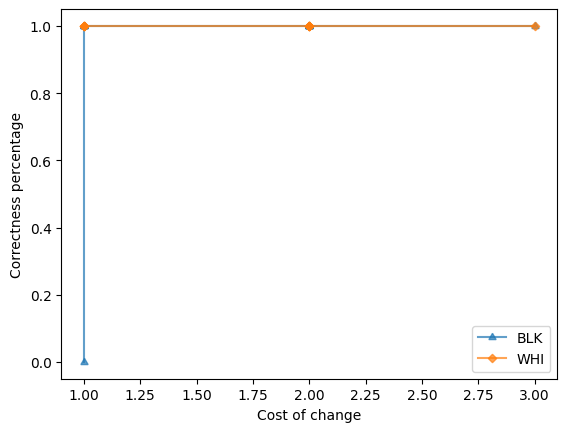

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 100.00% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL

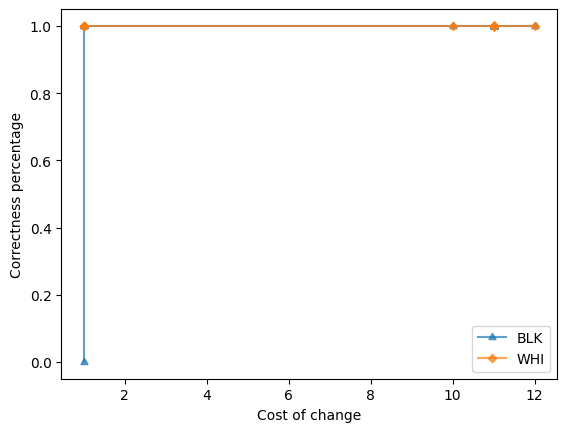

If PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 5.24% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 100.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectivene

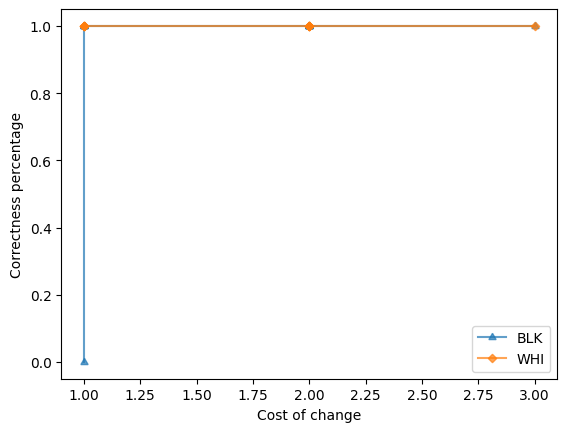

If PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 12.07% covered out of 7854
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1 with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.11% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 57.90% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 59.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 59.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 59.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectivene

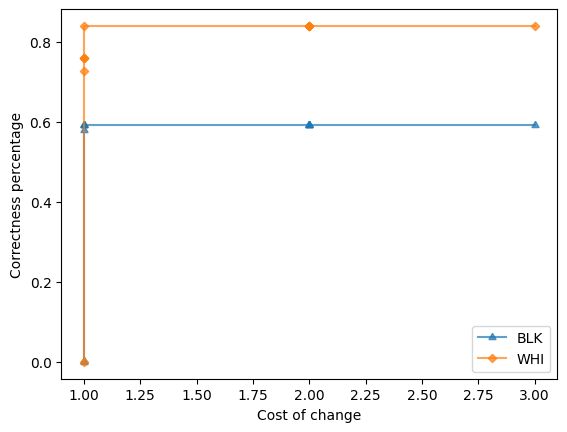

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 9.92% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 62.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 62.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 62.21% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 84.01% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 97.40% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT

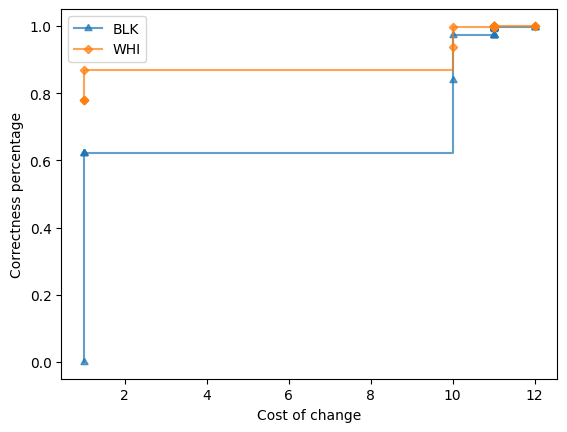

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.74% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACT

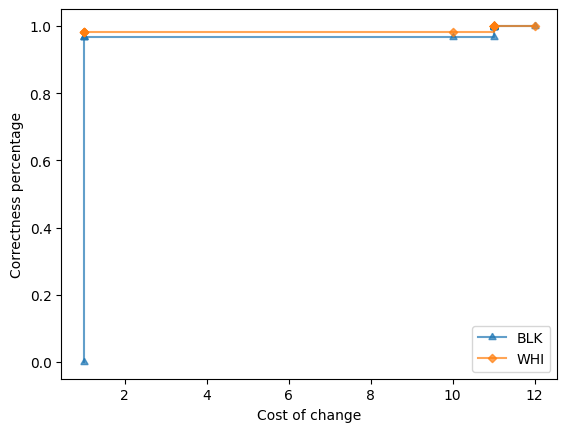

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT ARRESTS VIOLENT OFFENSES = 0, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 5.46% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 96.74% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 96.74% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PRED

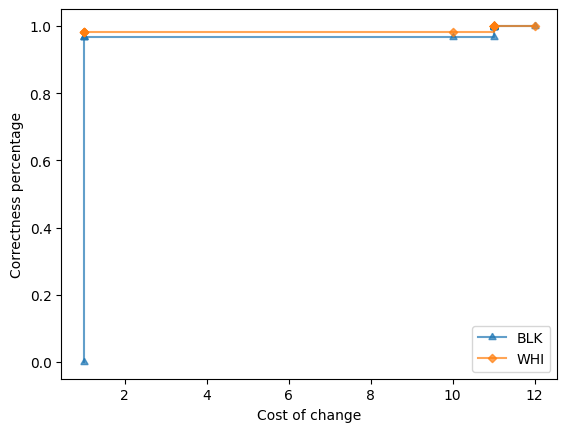

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 9.47% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 64.36% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 64.36% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 64.36% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 87.05% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 98.21% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT

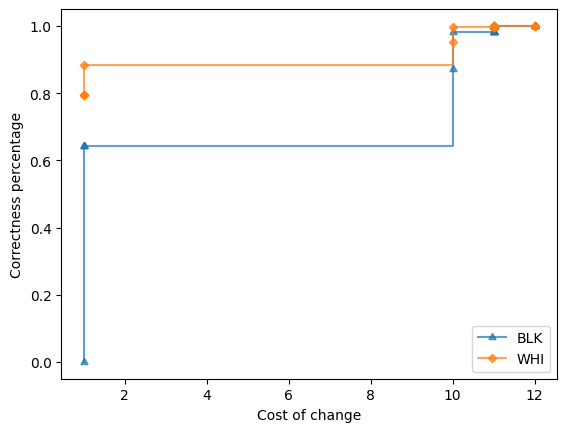

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 9.40% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 64.86% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 64.86% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 64.86% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 87.60% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 98.19% and counterfac

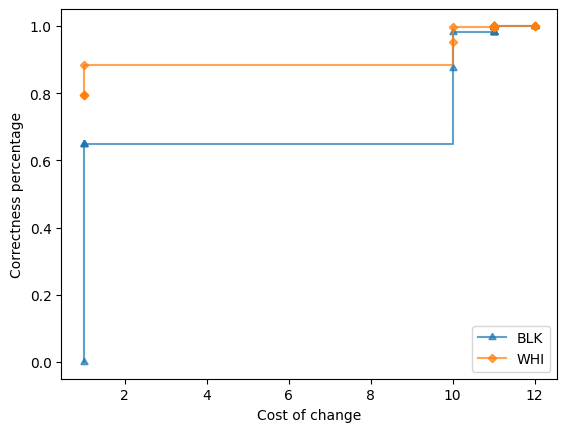

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 8.74% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.14% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 68.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 68.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 68.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 68.07% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 68.07% and coun

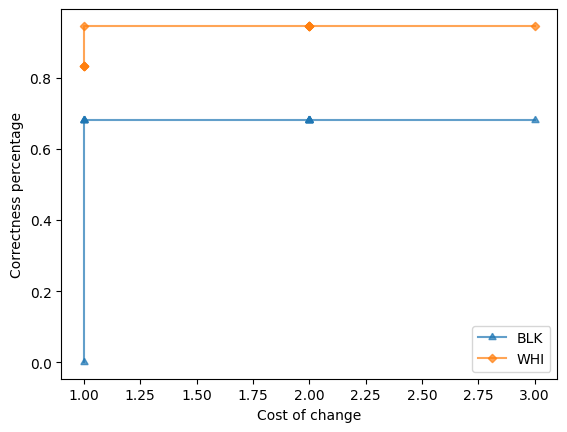

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 9.07% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.14% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 65.94% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 65.94% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 65.94% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 65.94% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 65.94% and counterfactual cost = 2.0.
		Make PREDICTOR RAT N

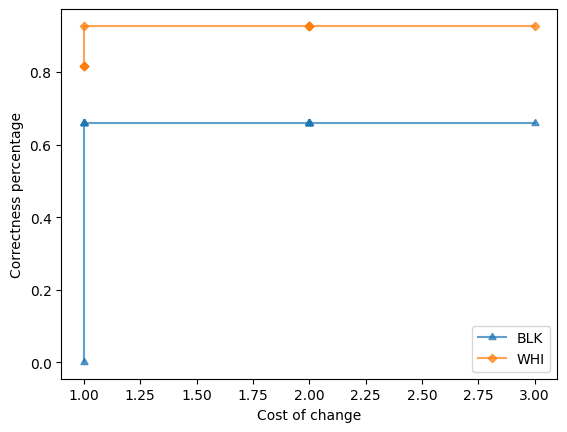

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 7.83% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.15% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 70.05% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 70.05% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 70.05% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 70.05% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 70.05% and coun

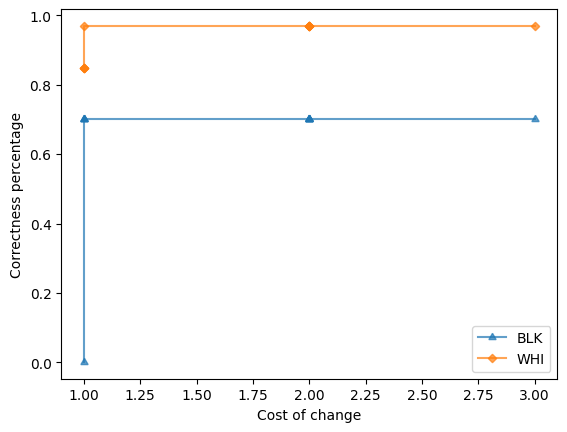

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 10.34% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 58.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 58.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 58.17% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 78.68% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 96.99% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDIC

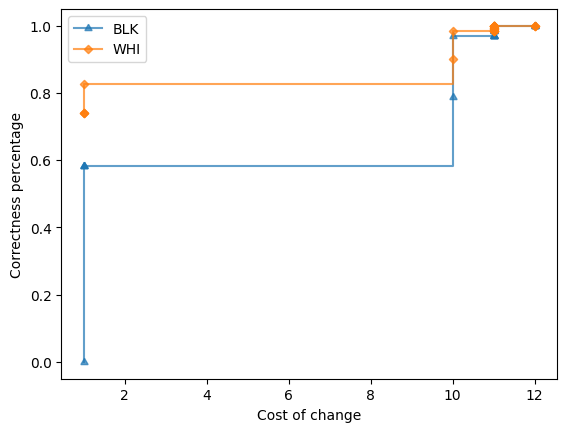

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 10.25% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 58.71% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 58.71% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 58.71% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 79.30% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 30-40 with effectiveness 96.96% and counterfactual cost = 10.0.
		Make PREDI

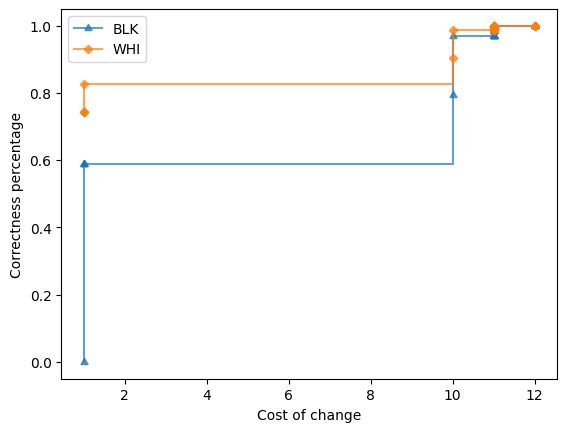

If PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 7.80% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.15% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 70.26% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 70.26% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 70.26% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.3, -0.2] with effectiveness 70.26% and counterfactual cost = 1.0.
		Make PREDICTOR RAT NARCOTIC ARRESTS = 1, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = 

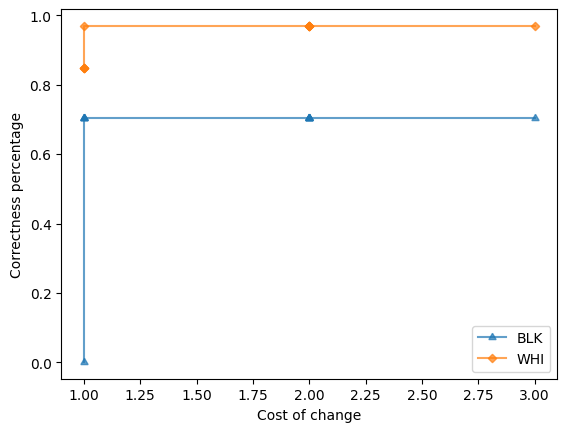

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0:
	Protected Subgroup 'BLK', 8.09% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 66.22% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 66.22% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 66.22% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 85.86% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 86.16% and counterfa

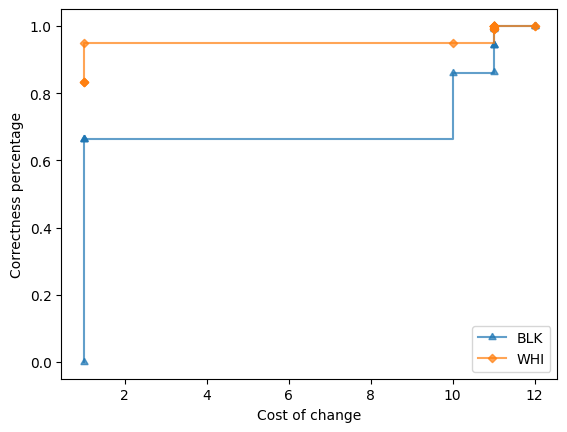

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0:
	Protected Subgroup 'BLK', 7.59% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 69.97% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 69.97% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 69.97% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 90.72% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1,

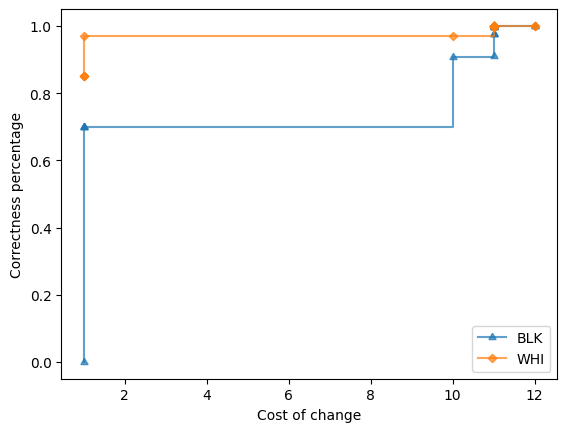

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 7.93% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 67.63% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 67.63% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 67.63% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 87.69% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1,

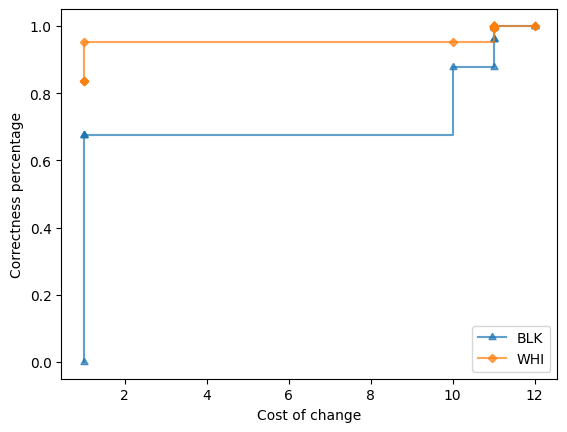

If PREDICTOR RAT AGE AT LATEST ARREST = 10-20, PREDICTOR RAT GANG AFFILIATION = 0, PREDICTOR RAT NARCOTIC ARRESTS = 0, PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.3, 7.3], PREDICTOR RAT UUW ARRESTS = 0, PREDICTOR RAT VICTIM BATTERY OR ASSAULT = 0, PREDICTOR RAT VICTIM SHOOTING INCIDENTS = 0:
	Protected Subgroup 'BLK', 7.58% covered out of 7854
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (0.1, 0.3] with effectiveness 0.00% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-8.200999999999999, -0.3] with effectiveness 70.19% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.1, 0.1] with effectiveness 70.19% and counterfactual cost = 1.0.
		Make PREDICTOR RAT TREND IN CRIMINAL ACTIVITY = (-0.2, -0.1] with effectiveness 70.19% and counterfactual cost = 1.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30 with effectiveness 91.01% and counterfactual cost = 10.0.
		Make PREDICTOR RAT AGE AT LATEST ARREST = 20-30, PRE

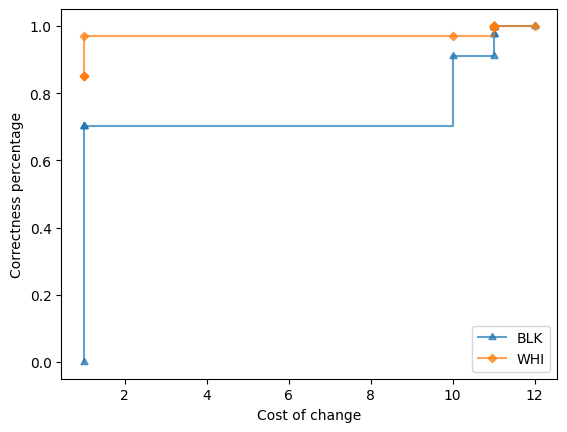

In [43]:
affected_pop_sizes = {sg: ((X_test["RACE CODE CD"] == sg) & (preds_Xtest == 0)).sum() for sg in X_test["RACE CODE CD"].unique()}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative,
    affected_pop_sizes,
    top_count=50
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True
)